# IQTREE Stats Notebook

---
# 0. SETUP

## Modules

In [1]:
import os
import pandas as pd
import geopandas
import shapely
import matplotlib.pyplot as plt
from matplotlib import colors,lines
import cartopy.crs as ccrs
import scipy
import datetime
from Bio import AlignIO, Phylo
import seaborn as sns
import subprocess
import geopy
from geopy import distance
import statsmodels.formula.api as smfa
import statsmodels.stats.multitest as smmt
import math
from skbio.stats import distance as skbio_dist
from functions import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sklearn

## Paths

In [2]:
try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    WILDCARDS = ["all", "chromosome", "full", "5"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
      
results_dir = os.path.join(project_dir, "results/")
READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
PRUNE = WILDCARDS[2]
MISSING_DATA = WILDCARDS[3]

results_dir = "/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/"

print(results_dir)

/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/


In [3]:
iqtree_dir    = os.path.join(results_dir, "iqtree/all/chromosome/{}/filter{}/".format(PRUNE, MISSING_DATA))


metadata_path = iqtree_dir    + "filter-taxa/metadata.tsv"
# ------------------------------------------
# Trees
divtree_path  = iqtree_dir    + "filter-taxa/iqtree.treefile"

if PRUNE == "prune":
    full_divtree_path = divtree_path.replace("prune","full")
    full_metadata_path = metadata_path.replace("prune","full")
else:
    full_divtree_path = divtree_path
    full_metadata_path = metadata_path

# ------------------------------------------
# Output
out_dir = iqtree_dir    + "filter-taxa/"
if not os.path.exists(out_dir):
    subprocess.run(["mkdir", "-p", out_dir]) 

## Variables

In [4]:
pd.set_option("display.max_rows", 10, "display.max_columns", None)

np.random.seed(1235423134)

NO_DATA_CHAR = "NA"
ALPHA = 0.05

# ------------------------------------------
# Time
CURRENT_YEAR = datetime.datetime.utcnow().year

# ------------------------------------------
# Geo
CRS = "epsg:3857"
CRS_EPSG = ccrs.epsg('3857')
world_polygons = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# ------------------------------------------
# Plotting
plt.rcParams['axes.facecolor']    ='white'
plt.rcParams['savefig.facecolor'] ='white'
plt.rcParams['savefig.dpi']       = 400
plt.rcParams['svg.fonttype']      = 'none'

---
# 1. IMPORT

## Trees

In [5]:
divtree = Phylo.read(divtree_path, "newick")
divtree.ladderize(reverse=False)

full_divtree = Phylo.read(full_divtree_path, "newick")
full_divtree.ladderize(reverse=False)

## Metadata

In [6]:
metadata_df = pd.read_csv(metadata_path, sep='\t', index_col = 0)
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

full_metadata_df = pd.read_csv(full_metadata_path, sep='\t', index_col = 0)
full_metadata_df.fillna(NO_DATA_CHAR, inplace=True)

## Colors

In [7]:
colors_dict = {}

# Initialize columns
metadata_df["population_color"] = [NO_DATA_CHAR] * len(metadata_df)
metadata_df["population"]       = [NO_DATA_CHAR] * len(metadata_df)

# Colors dictionary is based off full tree
for t in full_divtree.get_terminals():
    branch_minor = full_metadata_df["branch_minor"][t.name]
    branch_major = full_metadata_df["branch_major"][t.name]
    population = branch_major
    if branch_minor == "0.ANT4":
        population = branch_minor
    metadata_df.at[t.name, "population"] = population
    if population not in colors_dict and population != NO_DATA_CHAR:
        colors_dict[population] = ""


# Create the custom color map (pyplot)
cmap = plt.get_cmap("rainbow", len(colors_dict))
# Convert the color map to a list of RGB values
cmaplist = [cmap(i) for i in range(cmap.N)]
# Convert RGB values to hex colors
attr_hex = [colors.to_hex(col) for col in cmaplist]

# Assign colors to value
for population, color in zip(colors_dict, attr_hex):
    colors_dict[population] = color
# Add NA
colors_dict[NO_DATA_CHAR] = "#c4c4c4"

for c in divtree.get_terminals():
    sample = c.name
    population = metadata_df["population"][c.name]
    population_color = colors_dict[population]
    metadata_df.at[sample, "population_color"] = population_color

print(colors_dict)
#display(metadata_df)

{'0.PRE': '#8000ff', '0.PE': '#5148fc', '0.ANT': '#238af5', '0.ANT4': '#0cc1e8', '3.ANT': '#3ae8d7', '4.ANT': '#68fcc1', '2.ANT': '#97fca7', '2.MED': '#c5e88a', '1.PRE': '#f3c16a', '1.ANT': '#ff8a48', '1.IN': '#ff4824', '1.ORI': '#ff0000', 'NA': '#c4c4c4'}


## Convert Dataframe to Geopandas

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,host_human,sequencing_technology,assembly_method,host_raw,host_order,population_color,population,geometry,root_rtt_dist,clade_rtt_dist,population_rtt_dist
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.783730,-100.445882,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992.0,29.0,0.0,38.725178,-105.607716,Human,NA,NA,Human,Human,#ff0000,1.ORI,POINT (-105.60772 38.72518),0.000073,NA,0.000006
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923.0,98.0,0.0,47.622245,40.795794,Human,IonTorrent,Newbler v. 2.6,Homo sapiens,Human,#c5e88a,2.MED,POINT (40.79579 47.62225),0.000073,NA,0.000010
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006.0,15.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,#238af5,0.ANT,POINT (85.46335 42.48050),0.000054,NA,0.000012
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Frontopsylla elatoides,Siphonaptera,#238af5,0.ANT,POINT (85.46335 42.48050),0.000055,NA,0.000012
GCA_009669565.1_ASM966956v1_genomic,42118,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,#238af5,0.ANT,POINT (85.46335 42.48050),0.000055,NA,0.000012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA7313243_45,Azov38,[1400:1700],[-621:-321],Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Second Pandemic,1.PRE,1.PRE1,SAMEA7313243_45,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,47.622245,40.795794,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (40.79579 47.62225),0.000075,NA,0.000022
SAMEA7313246_49,Gdansk8,[1400:1700],[-621:-321],Poland,Pomeranian Voivodeship,52.215933,19.134422,54.2456,18.1099,Second Pandemic,1.PRE,1.PRE1,SAMEA7313246_49,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,54.245560,18.109900,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (18.10990 54.24556),0.000060,NA,0.000007
SAMEA6651390,AGU010,[1435:1477],[-586:-544],Lithuania,Vilnius County,55.350000,23.750000,54.8227,25.2495,Second Pandemic,1.PRE,1.PRE1,SAMEA6651390,KEEP: SRA Ancient,1,Europe,1456.0,565.0,21.0,54.822692,25.249534,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (25.24953 54.82269),0.000060,NA,0.000006


{'11.4038717,48.9467562': 1, '24.30261214859043,58.31950685': 1, '25.03115989218585,55.9156048': 1, '97.0979974,63.3233807': 1, '82.69314240000001,52.6932243': 1, '104.719221,56.6370122': 1}
{'-105.607716,38.7251776': 1, '40.7957942,47.6222451': 4, '85.4633464,42.4804953': 105, '45.6985005,43.39761470000001': 2, '93.8582593,51.4017149': 4, '43.4204809,43.44282860000001': 4, '47.14988017944229,43.0883099': 16, '41.7267991,43.7368326': 4, '45.25441108731086,41.17390635': 1, '89.8549358,48.5470083': 9, '95.9325806,45.3463139': 3, '91.26731219782693,48.0552065': 1, '102.7237769,45.8297039': 1, '-111.763275,34.395342': 2, '-118.755997,36.7014631': 3, '75.45197267868438,41.3564711': 1, '127.999992,48.00000470000001': 2, '32.2166578,1.5333553999999998': 1, '46.4416422,-18.9249604': 2, '102.0,25.0': 18, '46.6145685,-21.743247': 1, '-56.123559,-15.616066': 1, '75.6741579,18.906835600000004': 2, '44.979682,43.1655309': 4, '43.8276008,40.8294349': 7, '45.60713327015354,39.43858165': 1, '46.705009

<GeoAxesSubplot:>

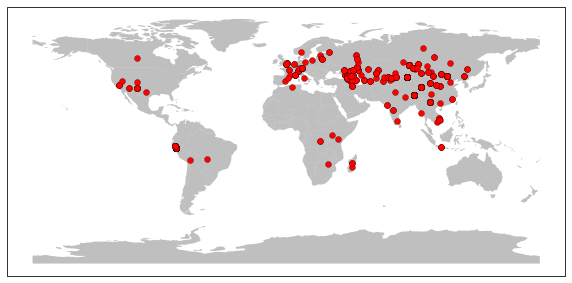

In [8]:
size_by_pop   = {}
size_by_coord  = {}
geometry = []

# Create geometry size dict
for rec in metadata_df.iterrows():
    sample = rec[0]
    population = rec[1]["population"]
    
    # Store the province, unless it's missing, then use country
    geo_name = rec[1]["province"]
    lat = rec[1]["province_lat"]
    lon = rec[1]["province_lon"]  
    
    if geo_name == NO_DATA_CHAR:
        geo_name = rec[1]["country"]
        lat = rec[1]["country_lat"]
        lon = rec[1]["country_lon"]   
        
    metadata_df.at[sample, "lat"] = lat
    metadata_df.at[sample, "lon"] = lon
    point = shapely.geometry.Point(lon,lat)  
    geometry.append(point)
    str_point = str(point.x) + "," + str(point.y)
        
    # Add Population to Dict
    if population not in size_by_pop:
        size_by_pop[population] = {}         
        
    # Add counter to the size_by_pop
    if geo_name not in size_by_pop[population]:
        size_by_pop[population][str_point] = 0
    size_by_pop[population][str_point] += 1
    
    # Add counter to size by coord
    if str_point not in size_by_coord:
        size_by_coord[str_point] = 0
    size_by_coord[str_point] += 1

metadata_gdf = geopandas.GeoDataFrame(metadata_df, crs="epsg:3857", geometry=geometry)
display(metadata_gdf)

print(size_by_pop["0.PRE"])
print(size_by_coord)

# Generate a figure with two axes, one for CartoPy, one for GeoPandas
fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG},figsize=(10, 5))
world_polygons.plot(ax=ax, color="grey", alpha=0.5)
metadata_gdf.plot(ax=ax, c="red", ec="black", lw=0.25)

## Mapping

'\n# Population legend\npopulations = list(colors_dict.keys())\npopulations.remove(NO_DATA_CHAR)\npopulations.reverse()\n\n\npopulation_lines = [lines.Line2D([0], [0], color=colors_dict[population], lw=0, markersize=2, markeredgecolor="black", markeredgewidth=0.25, marker="o") \n                for population in populations]\npopulation_labels = populations\n\npopulation_legend = fig.legend(population_lines, \n           populations,\n           #ncol=len(populations),\n           ncol=1,\n           loc="center", \n           bbox_to_anchor=(0.2, 0.475),\n           frameon=True,\n            borderpad=0.5, \n            handletextpad=0.25, \n           labelspacing=0.5,\n           edgecolor="black",\n           title="Population",\n           fontsize=FONTSIZE / 2.25,\n           title_fontsize=FONTSIZE / 1.5,\n          )\npopulation_legend.get_frame().set_linewidth(0.25)\n\n    \n\n# Size Legend\ns = [ax.scatter(0,-9000, s=1, ec="black", c="white", lw=0.25),\n     ax.scatter(0,-90

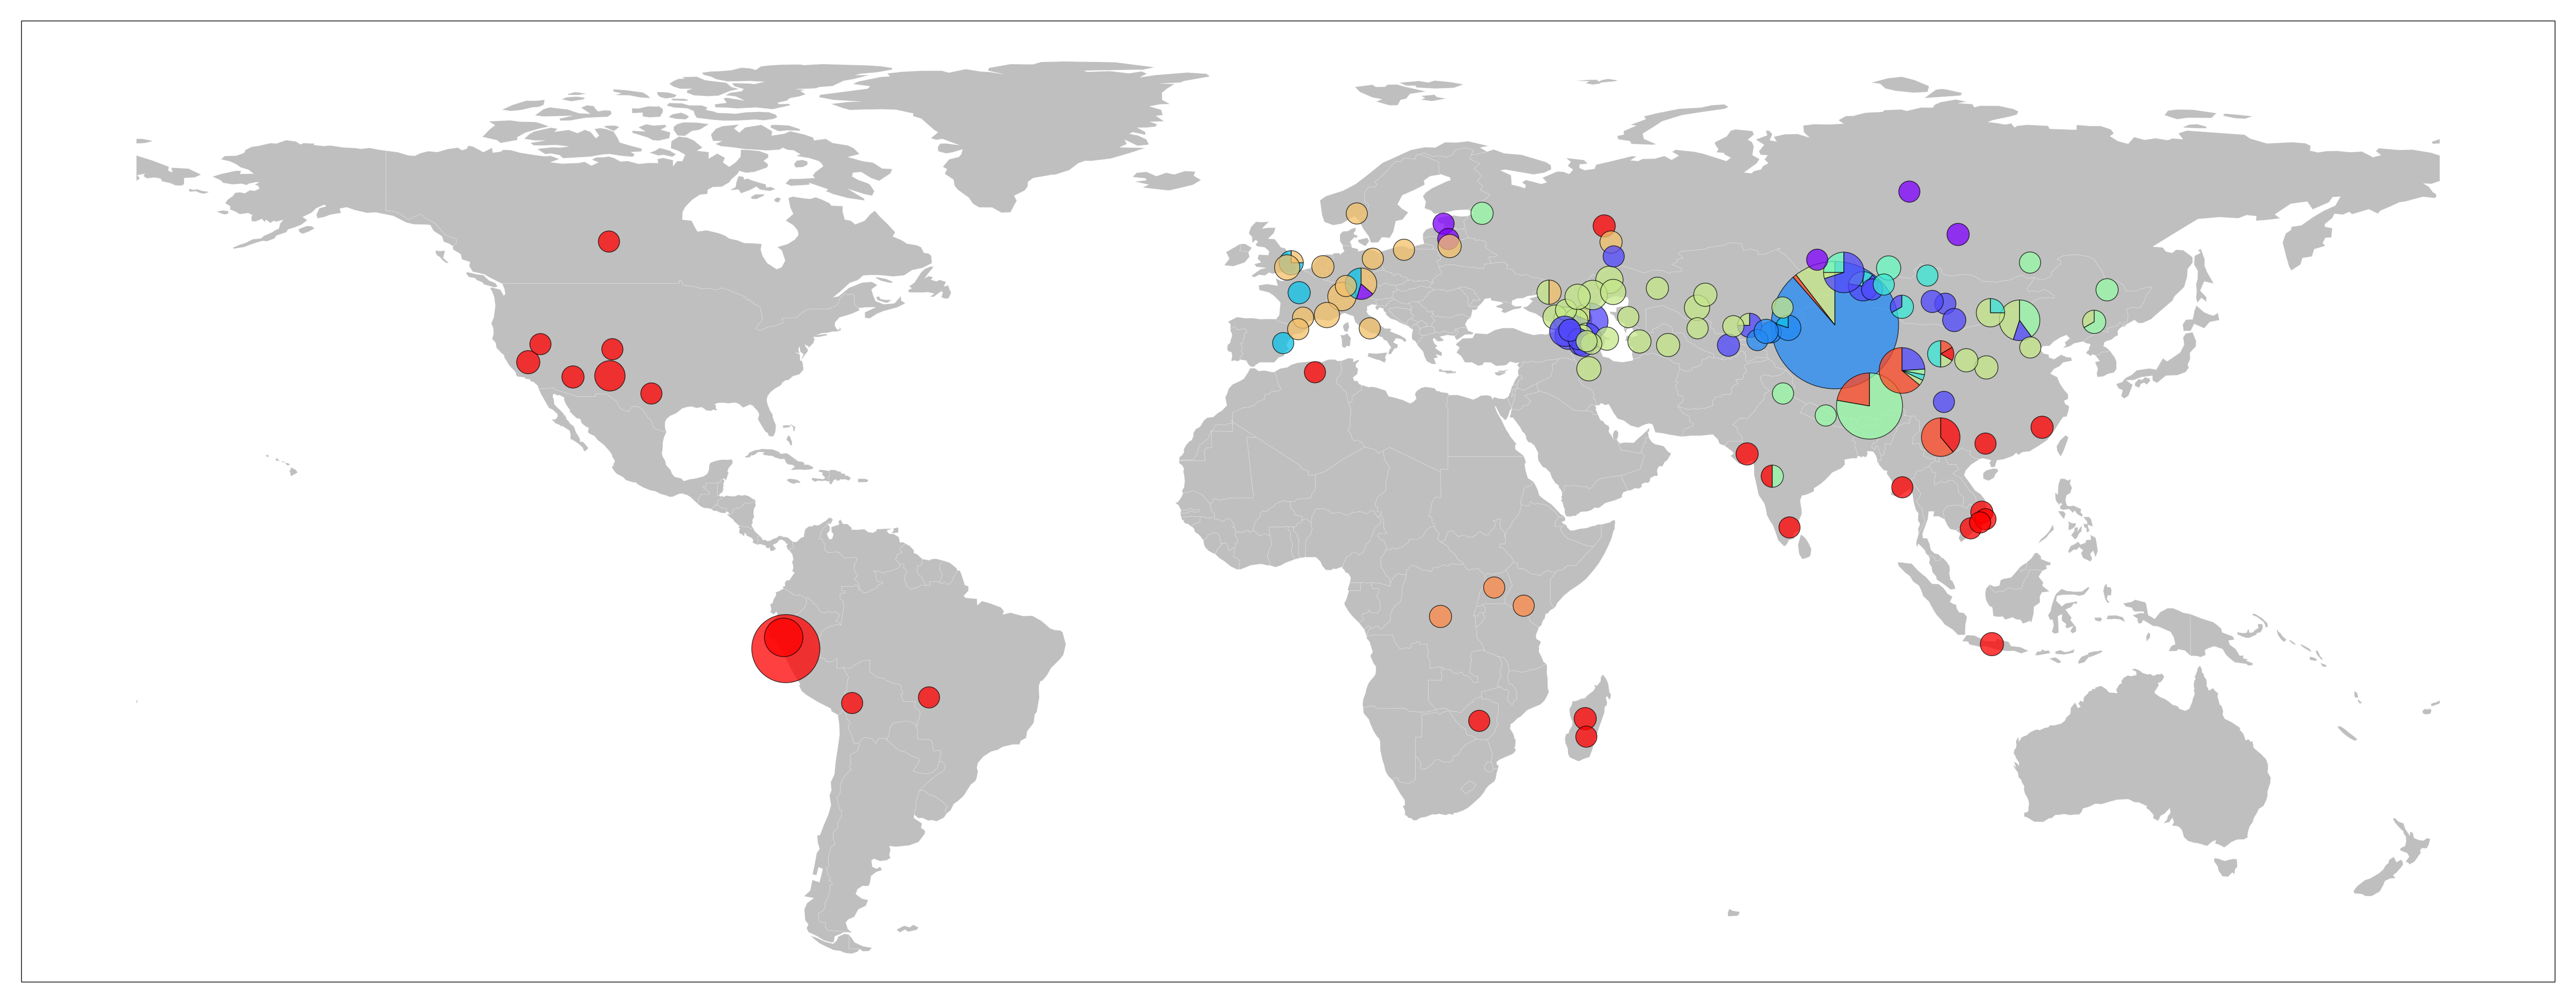

In [9]:
# ---------------------------------------
# PLOT SETUP

FONTSIZE=14
plt.rc('font', size=FONTSIZE)
DPI=400
FIGSIZE=[18,6]

## All
fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG},
                        figsize=FIGSIZE, dpi=DPI)

for spine in ax.spines:
    ax.spines[spine].set_linewidth(0.25)

# Sorry Antarctica
ax.set_ylim(-60,90)

world_polygons.plot(
    ax=ax, 
    zorder=1, 
    alpha=0.5, 
    color="grey",
    edgecolor="white", 
    linewidth=0.1,
) 

# Rescale the sizes for pie chart/inset axes
sizes = list(size_by_coord.values())
# Try to log values
#sizes = [math.log(s) for s in sizes]
# Convert to 2D array
sizes = np.reshape(np.array(sizes), (-1, 1))
rescale_max = 0.15
rescale_min = 0.025
sizes_rescale = sklearn.preprocessing.minmax_scale(sizes, feature_range=(rescale_min,rescale_max))
size_by_coord_rescale = {c:s[0] for c,s in zip(size_by_coord.keys(), sizes_rescale)}


i = 0
for coord in size_by_coord:
    # Get all samples from this coordinate
    coord_list = [float(c) for c in coord.split(",")]
    lon,lat = coord_list[0], coord_list[1]
    df = metadata_df[(metadata_df["lon"] == lon) & (metadata_df["lat"] == lat)]
    populations = set(df["population"])
    coord_colors = []
    sizes = []
    for pop in populations:
        num_samples = len(df[df["population"] == pop])
        color = colors_dict[pop]
        sizes.append(num_samples)    
        coord_colors.append(color)
        
    total_sizes = sum(sizes)
    ax_width = size_by_coord_rescale[coord]
    ax_width = size_by_coord_rescale[coord] * 5
    
   
    # Create an axis inset
    ax_sub=inset_axes(ax, width=ax_width, height=ax_width, loc=10, 
                       bbox_to_anchor=(lon, lat),
                       bbox_transform=ax.transData,
                       borderpad=0) 
    
    # Create pie chart
    wedges,texts= ax_sub.pie(
        sizes, 
        colors=coord_colors, 
        normalize=True,
        startangle=90,
        wedgeprops = {'linewidth': 0.25, 'edgecolor' : 'black', "alpha" : 0.75},
    )
    
    i += 1
    #if i > 20: break
    
"""
# Population legend
populations = list(colors_dict.keys())
populations.remove(NO_DATA_CHAR)
populations.reverse()


population_lines = [lines.Line2D([0], [0], color=colors_dict[population], lw=0, markersize=2, markeredgecolor="black", markeredgewidth=0.25, marker="o") 
                for population in populations]
population_labels = populations

population_legend = fig.legend(population_lines, 
           populations,
           #ncol=len(populations),
           ncol=1,
           loc="center", 
           bbox_to_anchor=(0.2, 0.475),
           frameon=True,
            borderpad=0.5, 
            handletextpad=0.25, 
           labelspacing=0.5,
           edgecolor="black",
           title="Population",
           fontsize=FONTSIZE / 2.25,
           title_fontsize=FONTSIZE / 1.5,
          )
population_legend.get_frame().set_linewidth(0.25)

    

# Size Legend
s = [ax.scatter(0,-9000, s=1, ec="black", c="white", lw=0.25),
     ax.scatter(0,-9000, s=10, ec="black", c="white", lw=0.25), 
    ax.scatter(0,-9000, s=100, ec="black", c="white", lw=0.25),     
    ]
sl = ["1", "10", "100"]
leg_size = fig.legend(s, sl, title="Genomes", loc="center",  borderpad=0.5, bbox_to_anchor=[0.3,0.45], edgecolor="black",
                    fontsize=FONTSIZE / 2, title_fontsize=FONTSIZE / 1.5)
leg_size.get_frame().set_linewidth(0.25)


out_path = os.path.join(out_dir, "map_all")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")"""


## Individual map by population

0.PRE
0.PE
0.ANT
0.ANT4
3.ANT
4.ANT
2.ANT
2.MED
1.PRE
1.ANT
1.IN
1.ORI


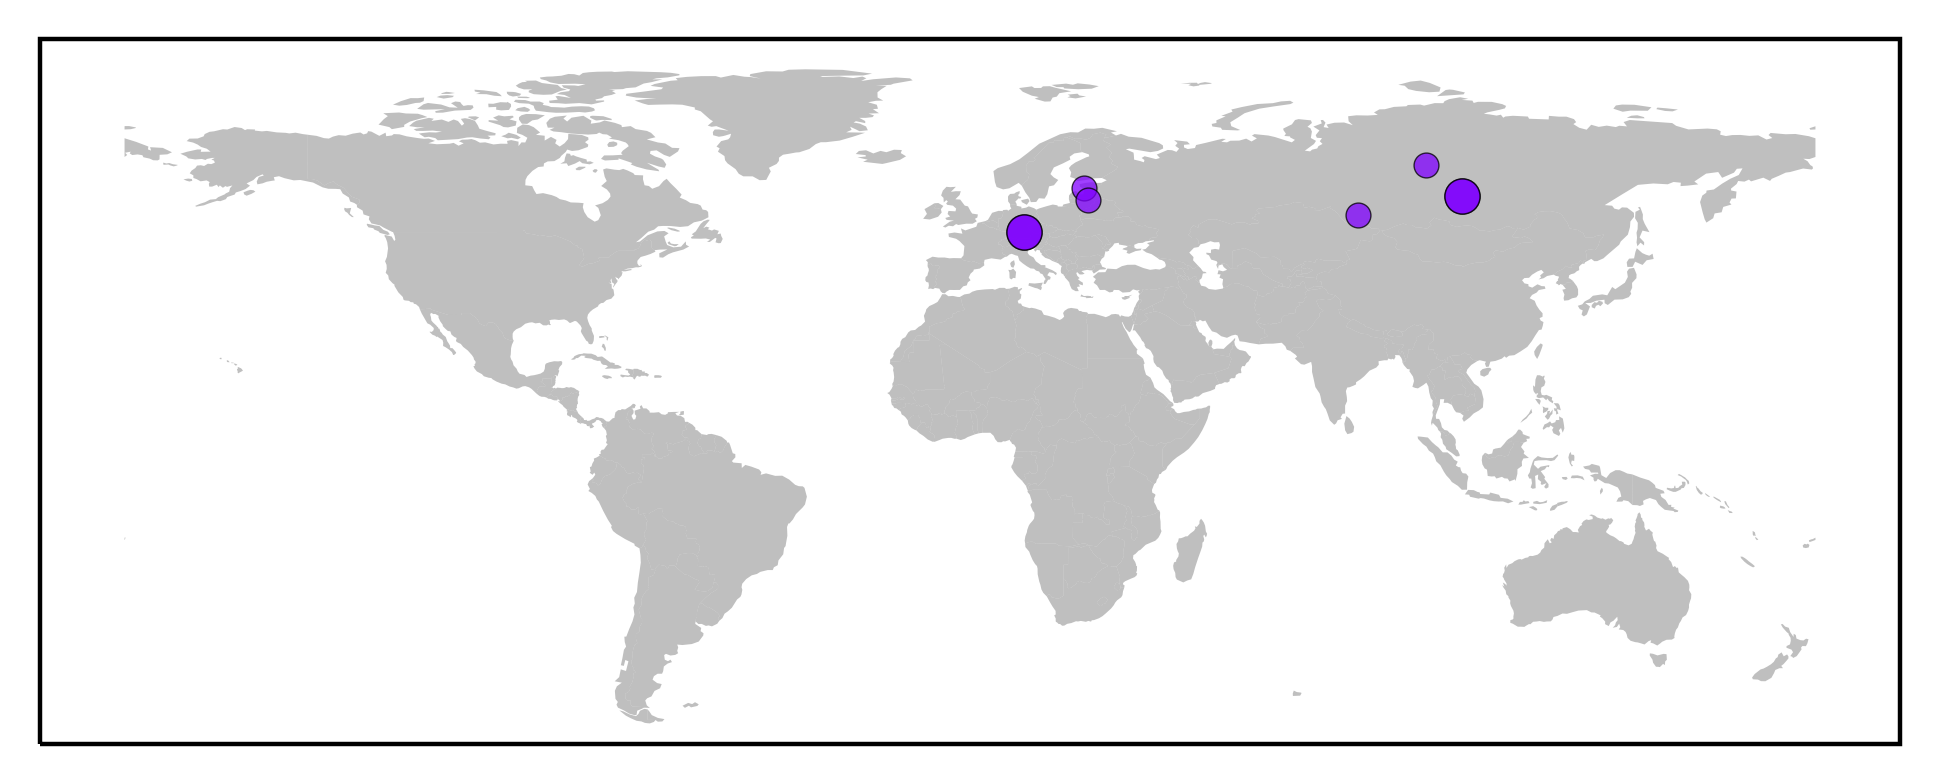

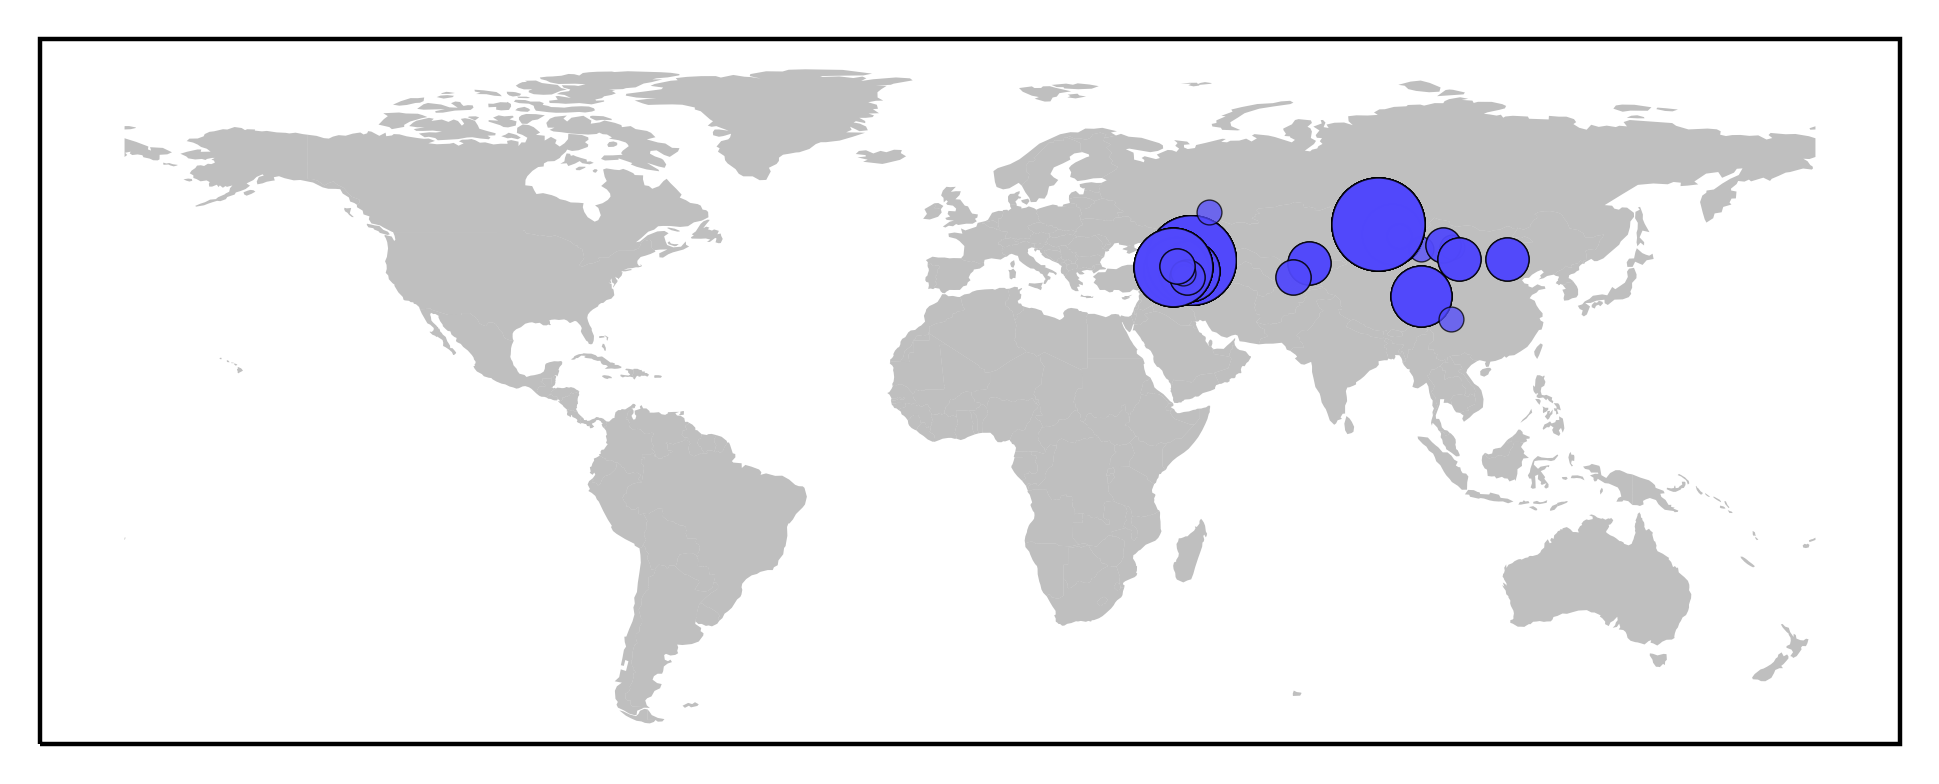

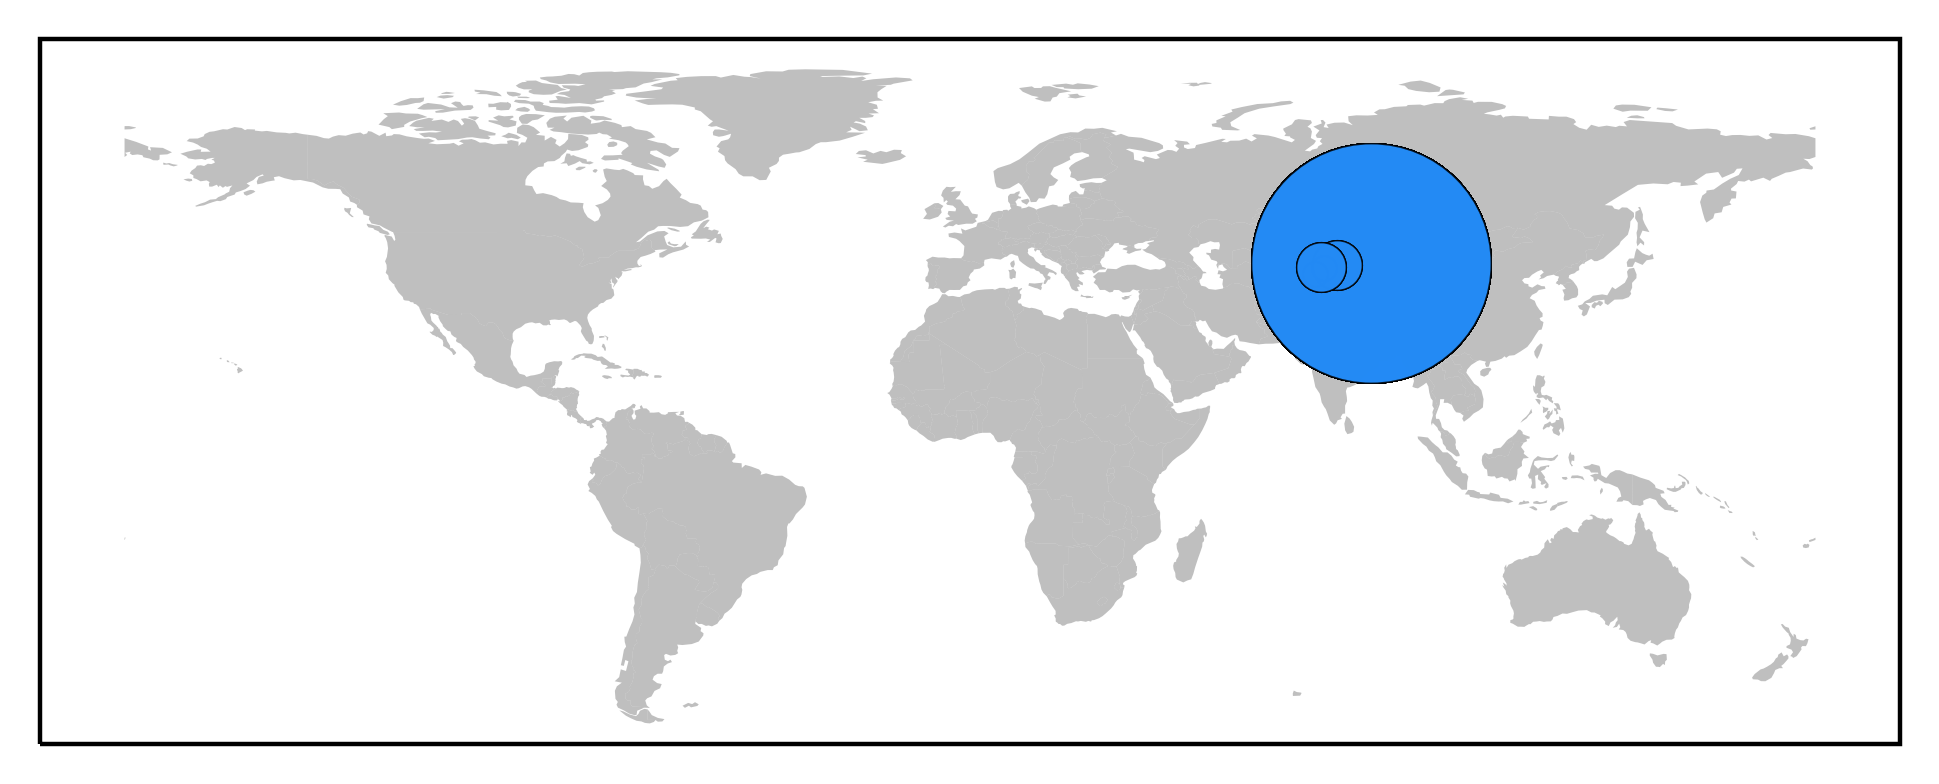

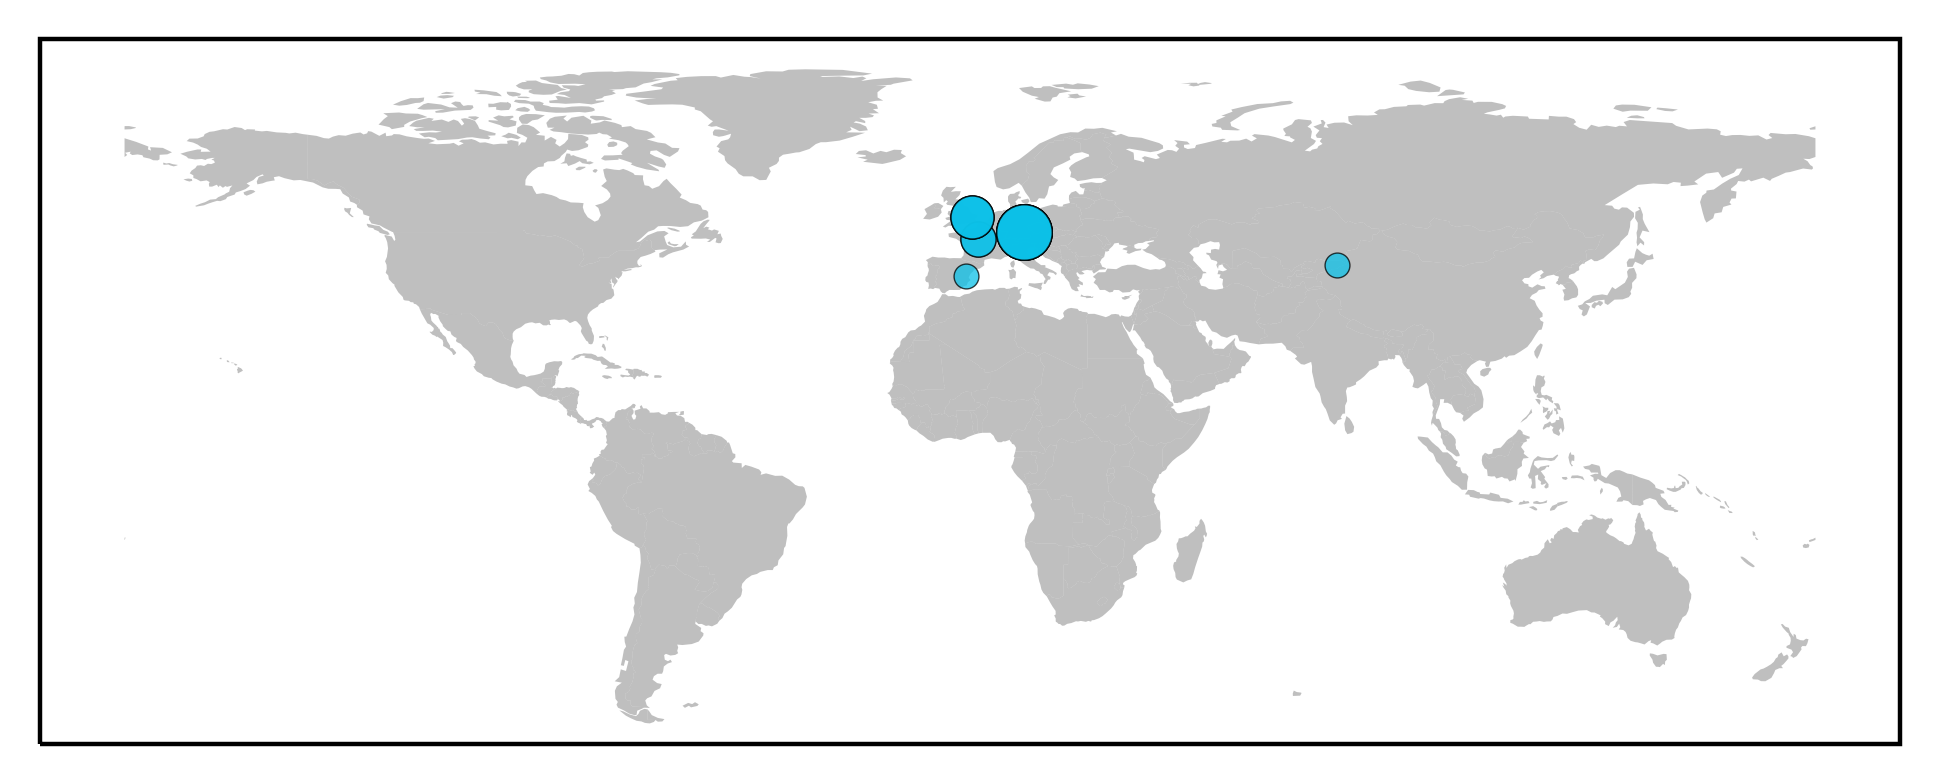

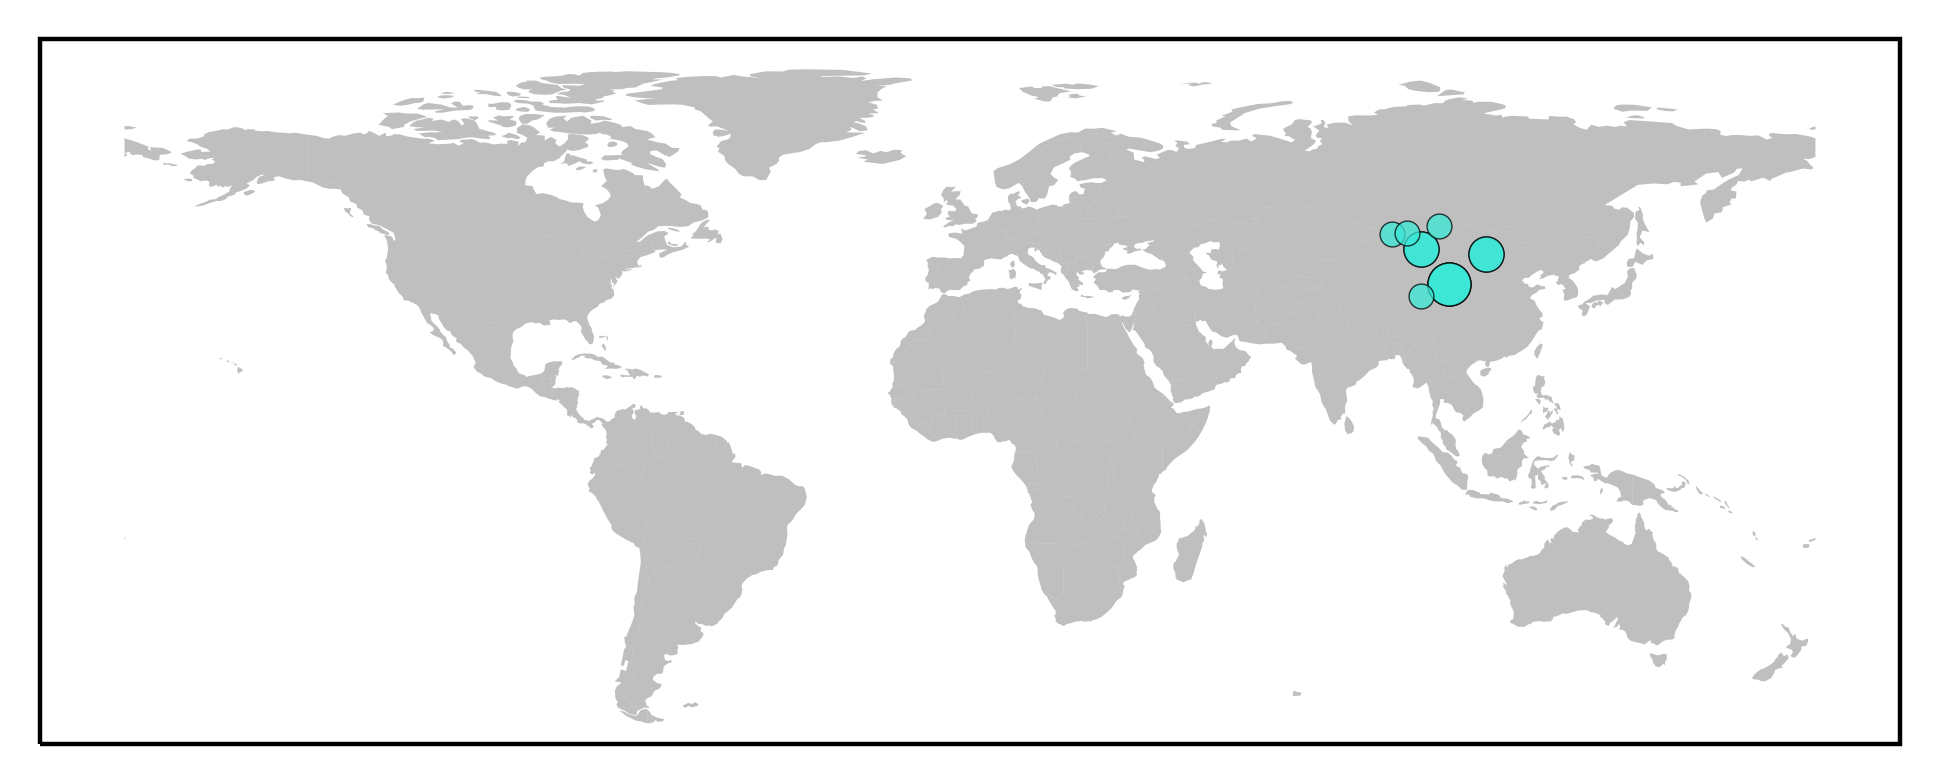

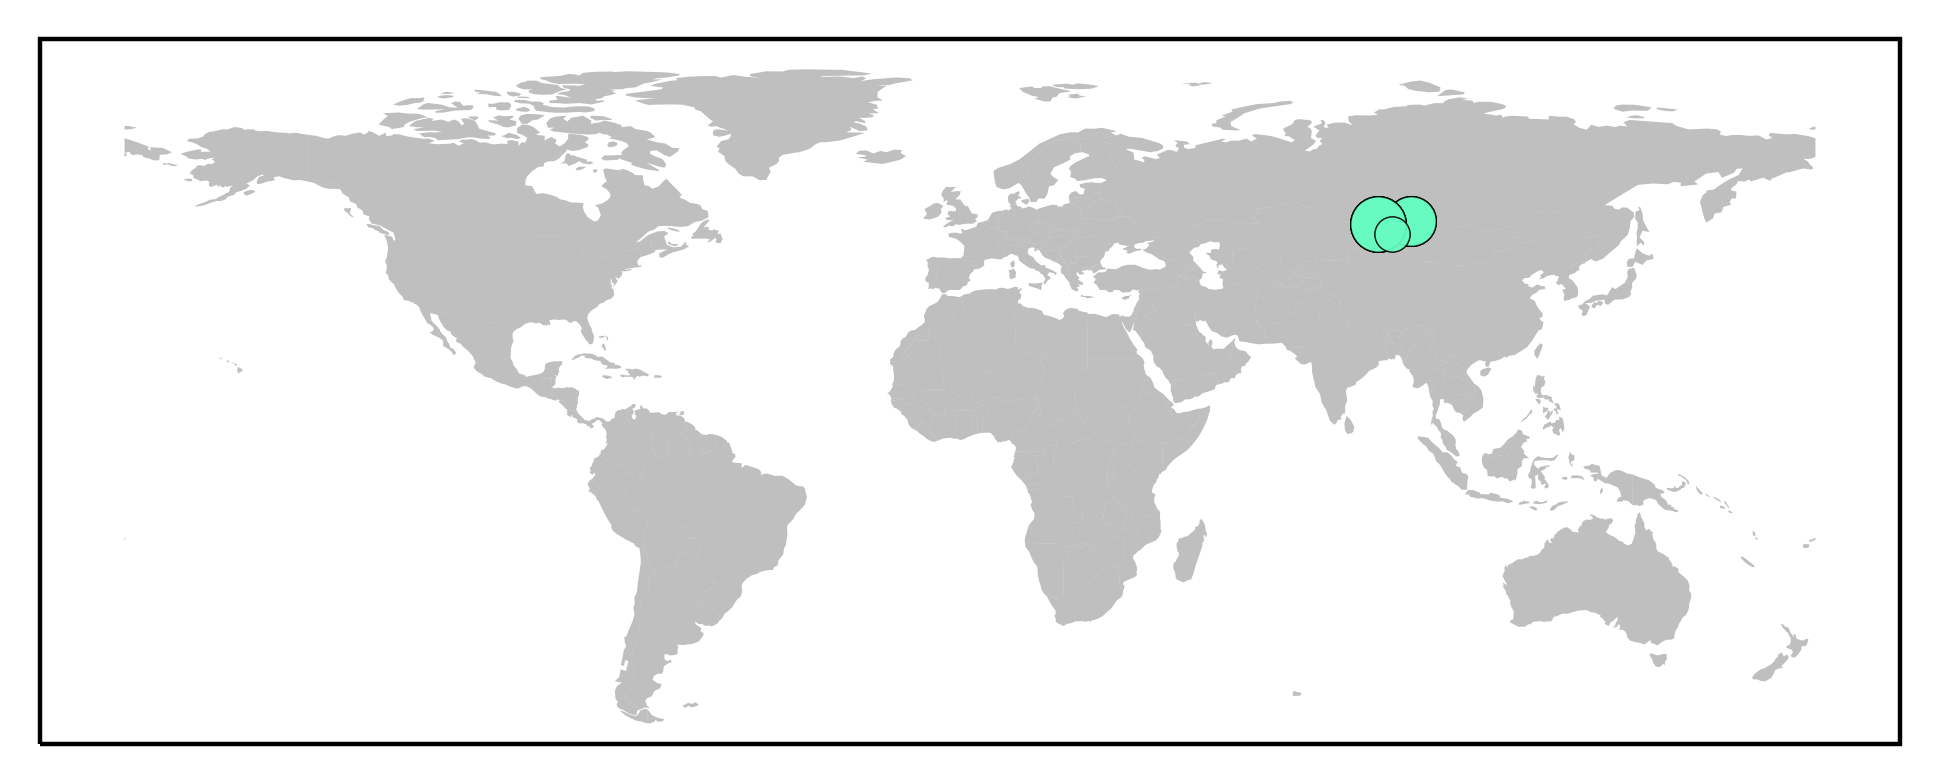

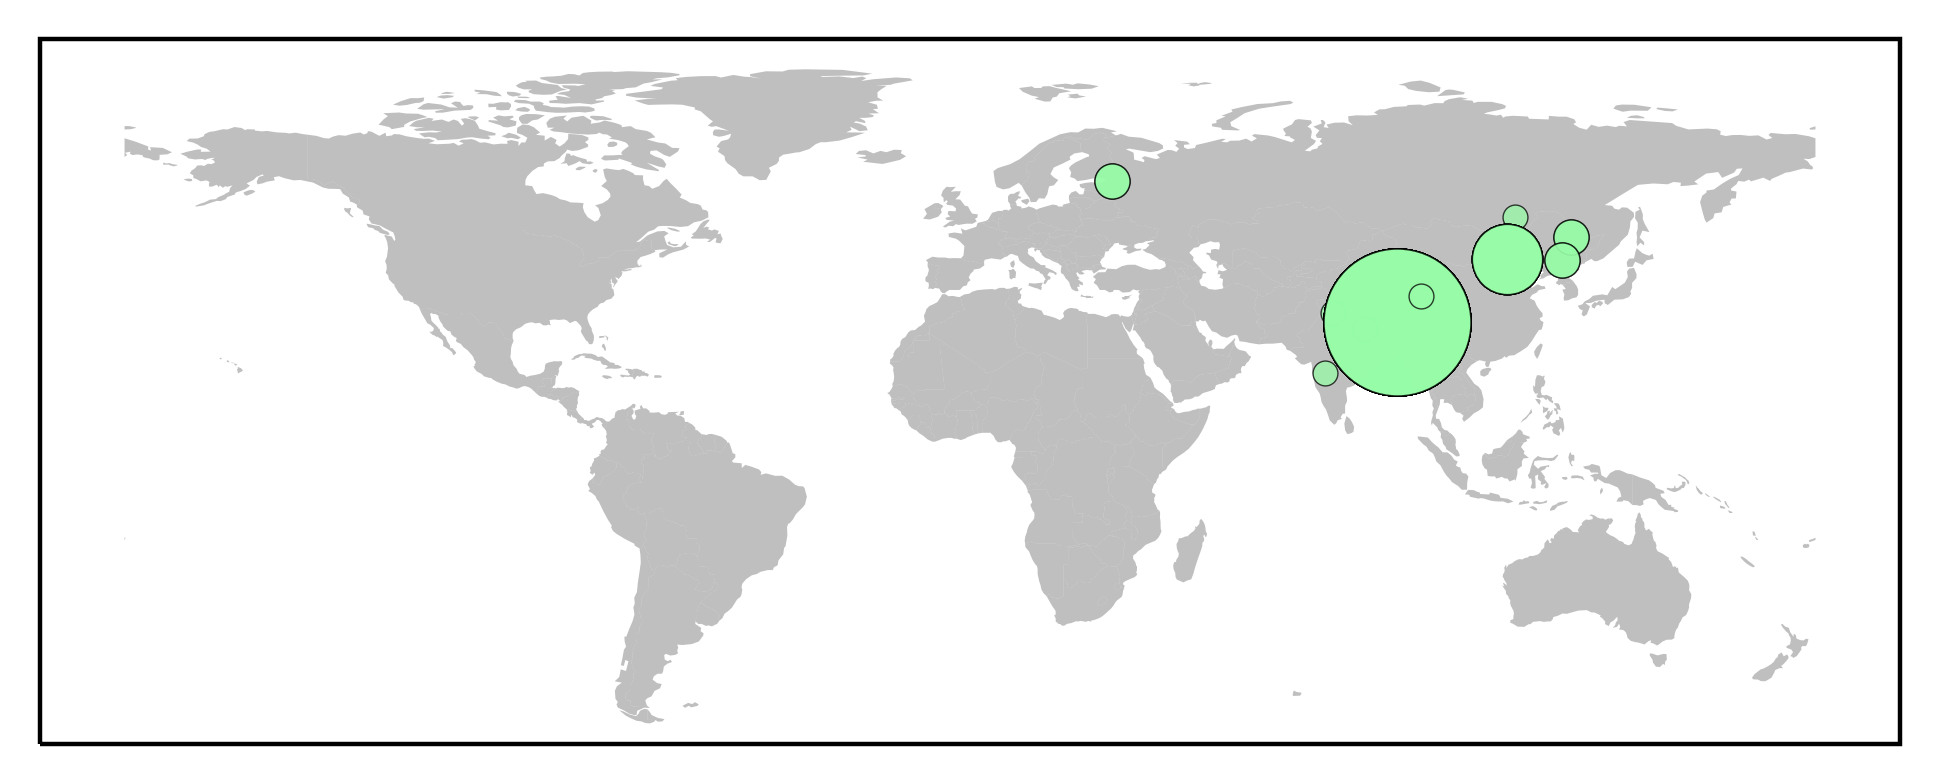

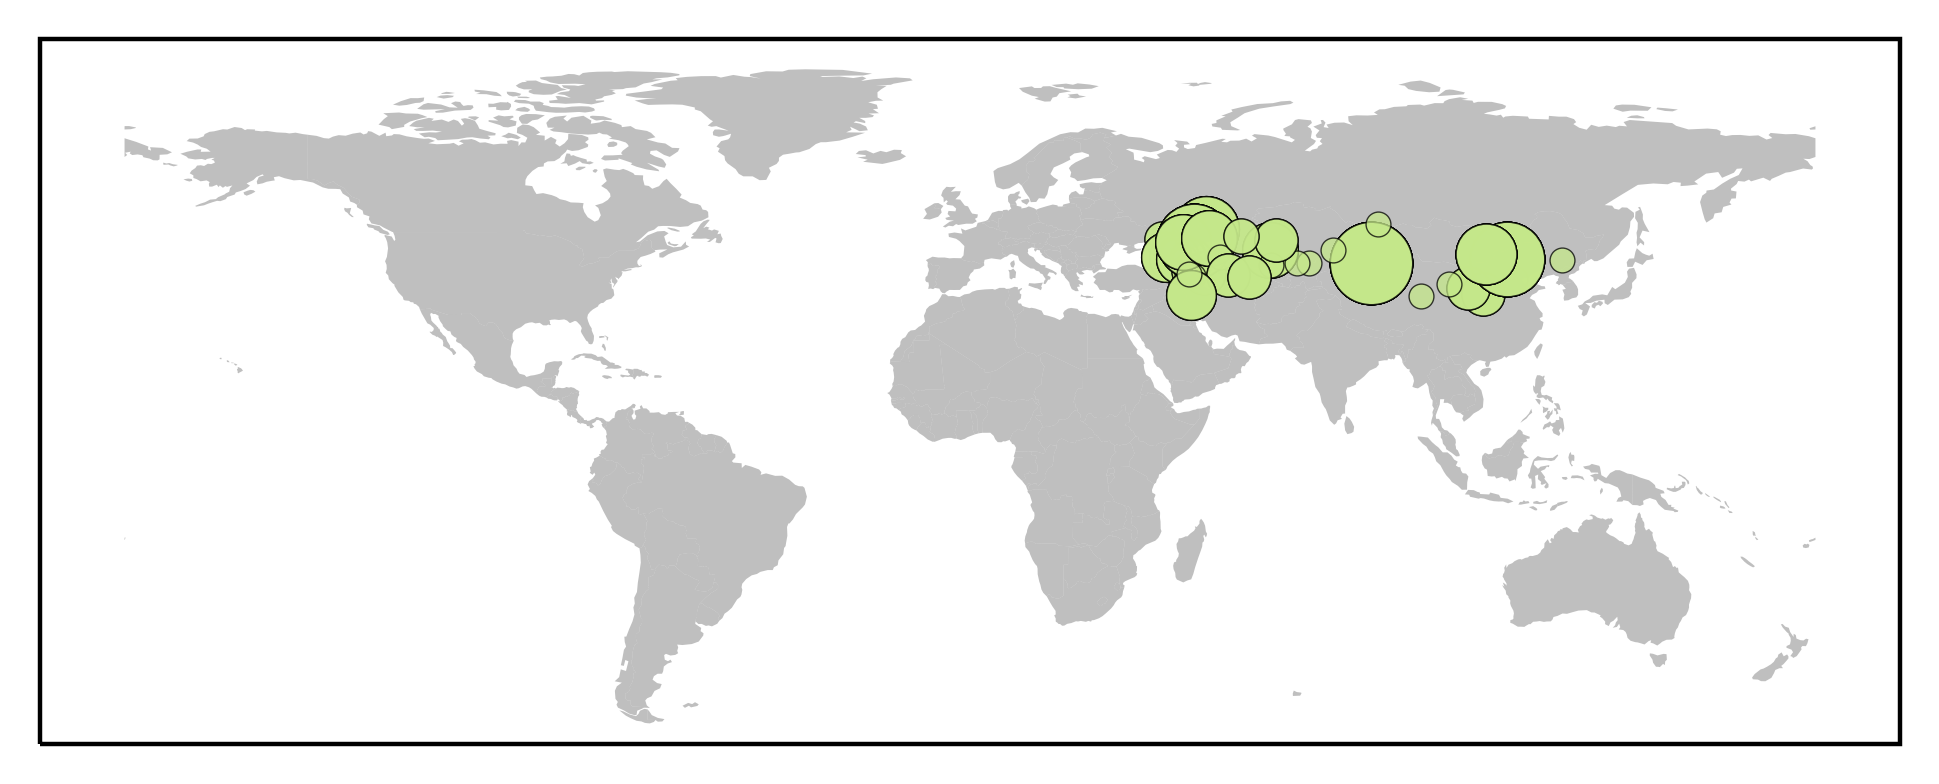

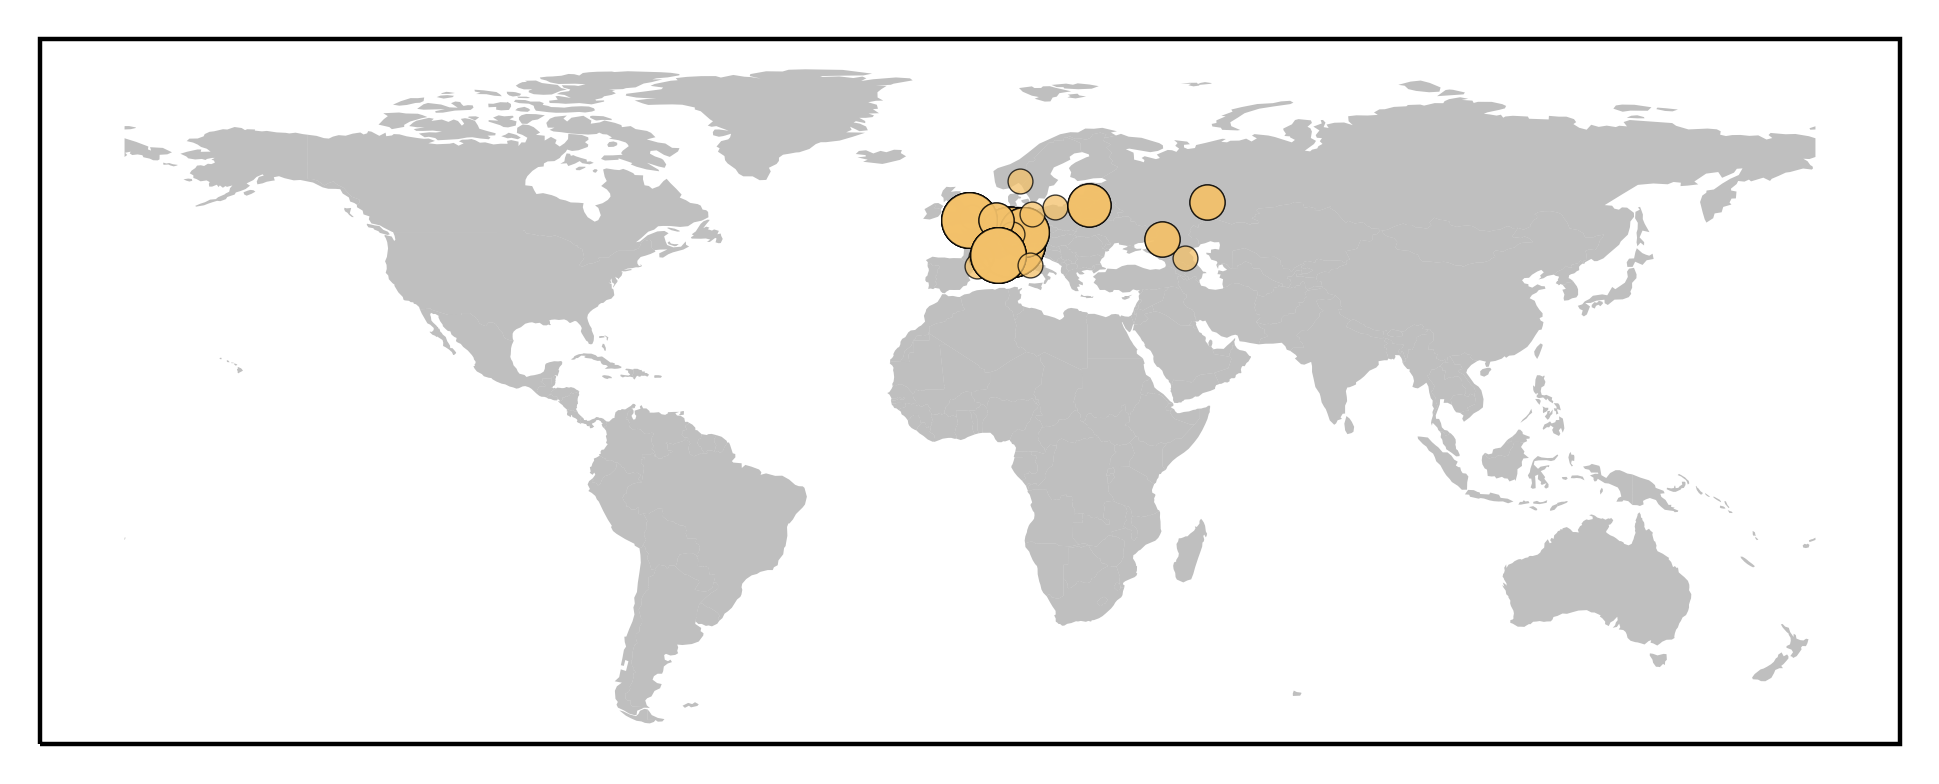

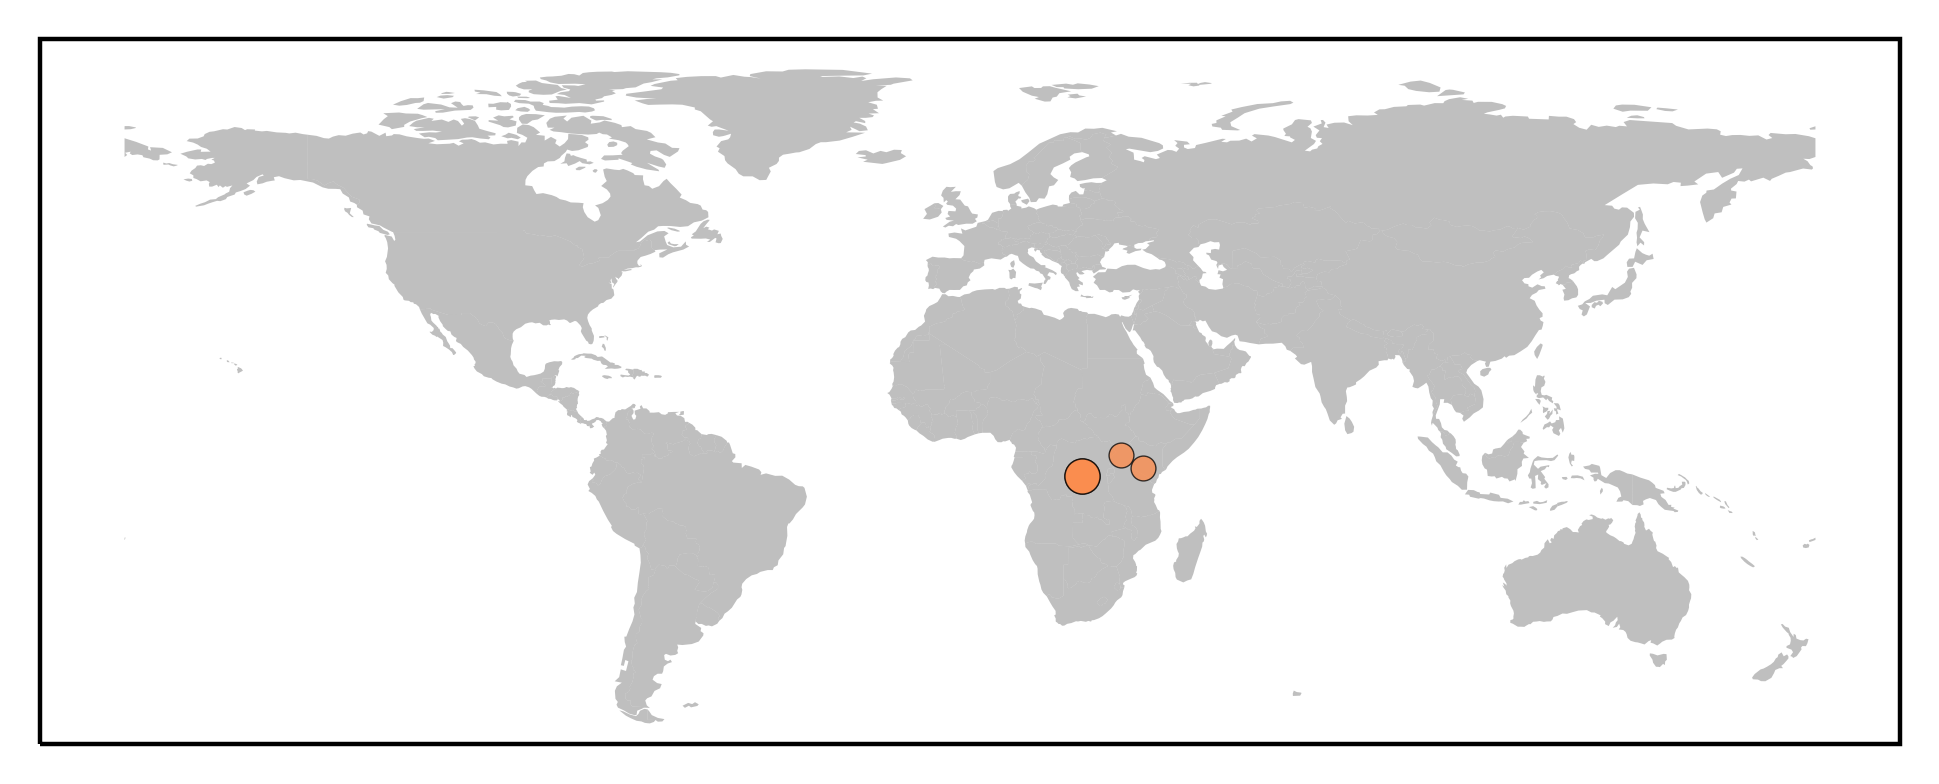

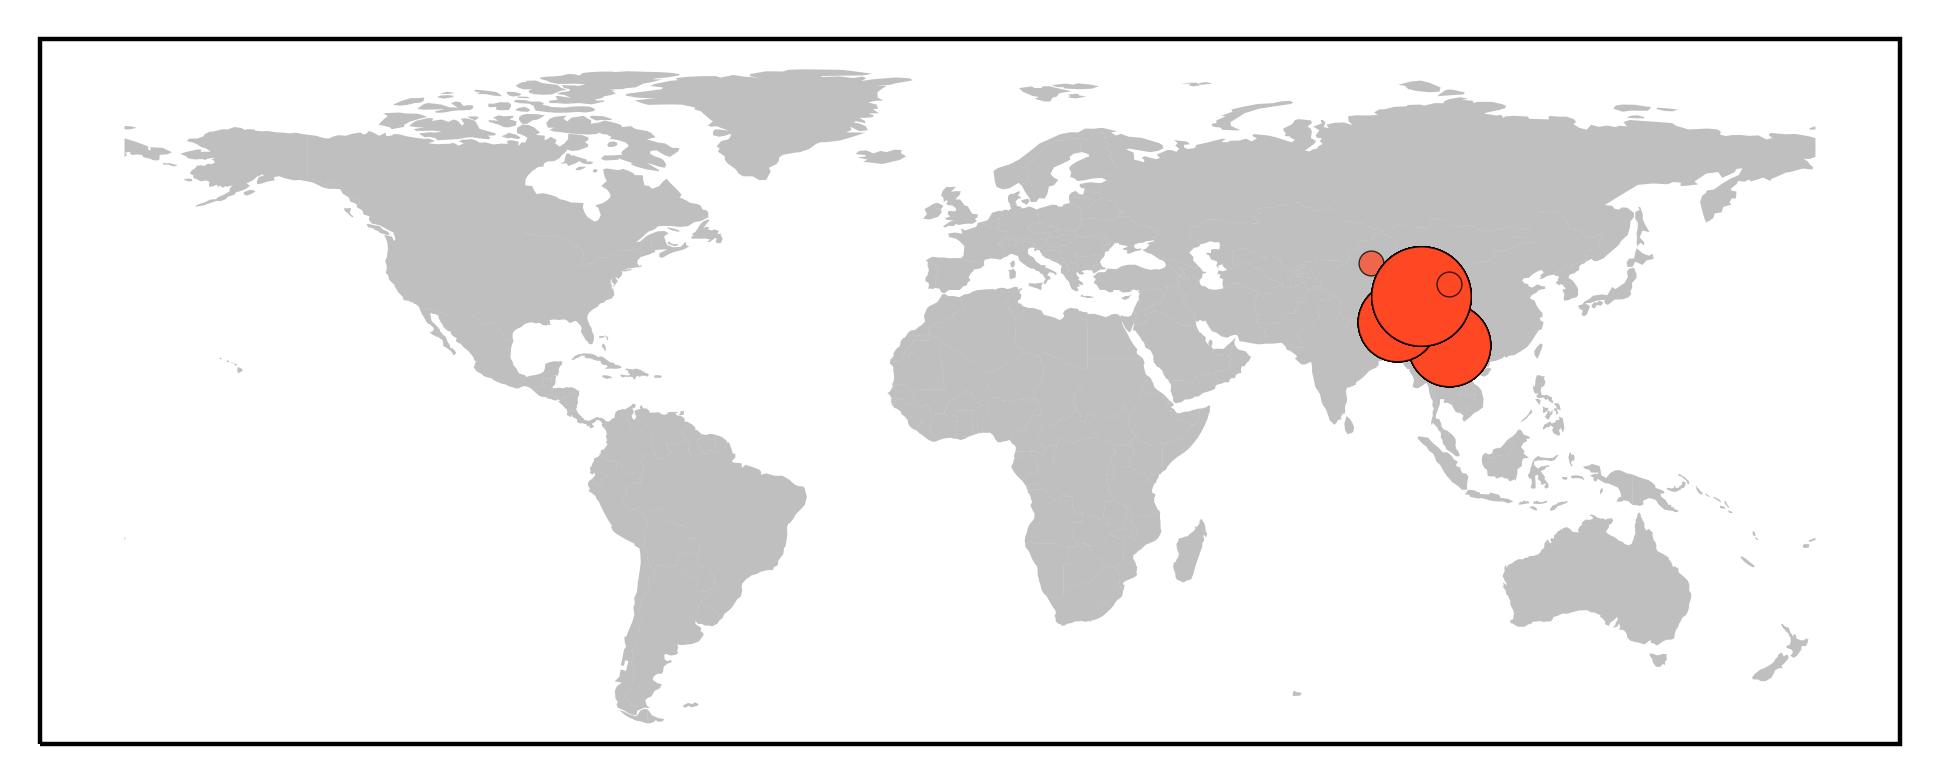

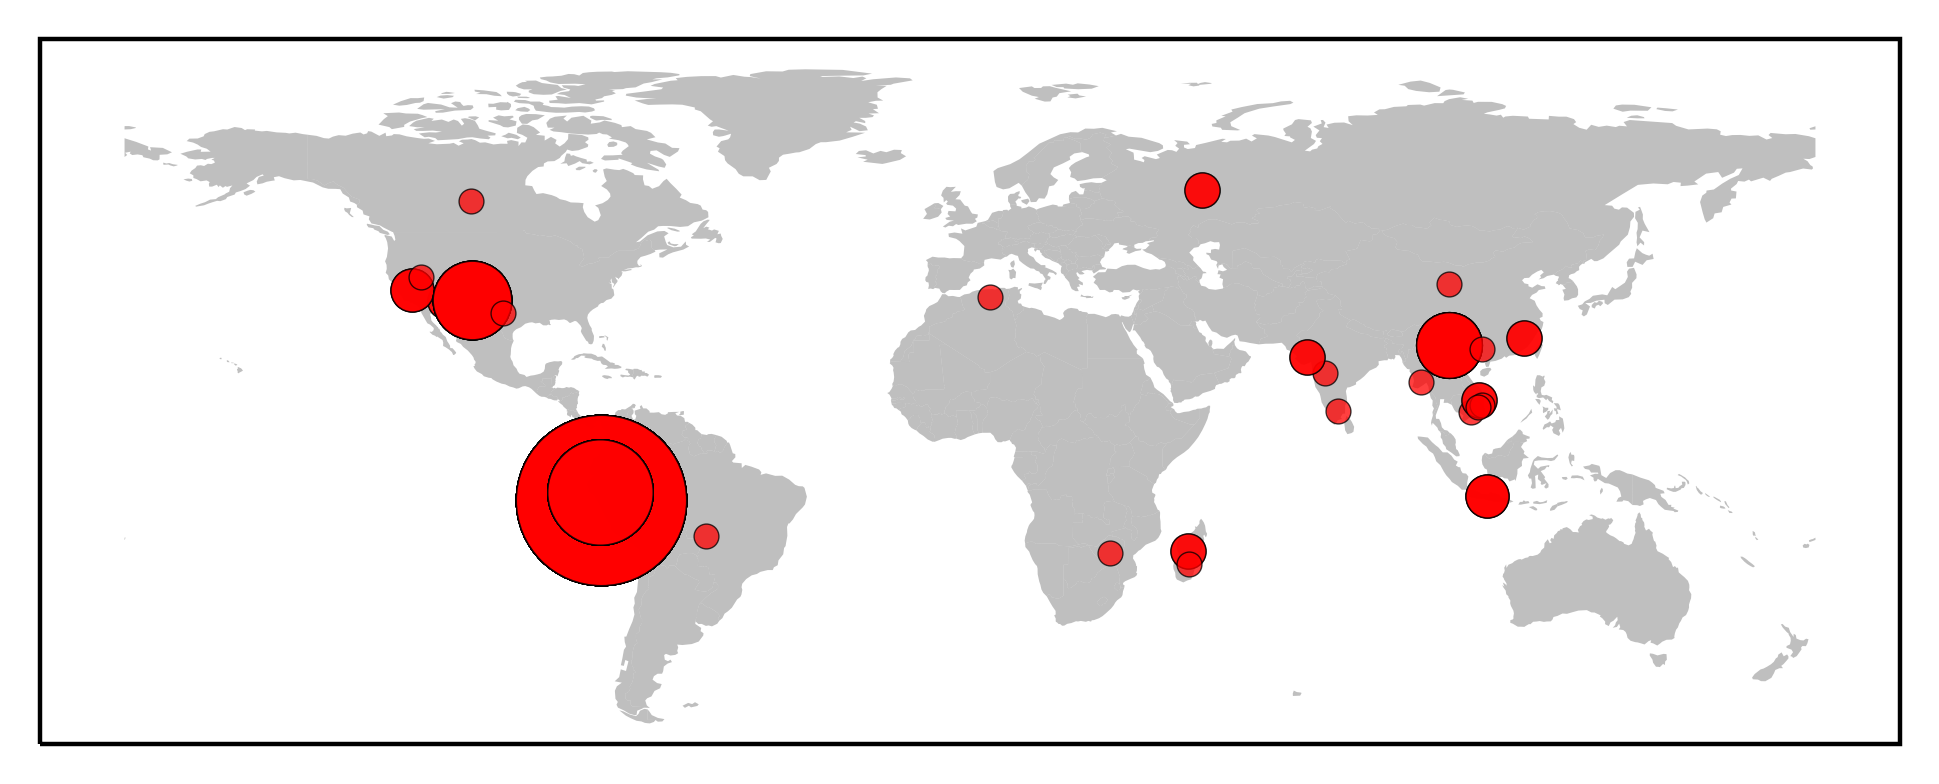

In [10]:
population_list = list(colors_dict.keys())
population_list.remove(NO_DATA_CHAR)

FONTSIZE=12
plt.rc('font', size=FONTSIZE)
DPI=400
FIGSIZE=[6,3]

for population in population_list:
    print(population)

    fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG}, figsize=FIGSIZE, dpi=DPI)

    # Sorry Antarctica
    ax.set_ylim(-60,90)
    color = colors_dict[population]

    world_polygons.plot(
        ax=ax, 
        zorder=1, 
        alpha=0.5, 
        color="grey",
        edgecolor="grey", 
        linewidth=0,
    ) 
    
    for coord in size_by_pop[population]:
        coord_list = [float(c) for c in coord.split(",")]
        lon,lat = coord_list[0], coord_list[1]
        gdf = metadata_gdf[(metadata_gdf["population"] == population) & (metadata_gdf["lon"] == lon) & (metadata_gdf["lat"] == lat)]
        num_samples = len(gdf)
        marker_scale = 20
        gdf.plot(
            ax=ax, 
            c=color, 
            ec="black", 
            lw=0.25, 
            markersize=num_samples * marker_scale,
            alpha=0.75,
        )
        
    out_path = os.path.join(out_dir, "map_{}".format(population))
    plt.savefig(out_path + ".png", bbox_inches="tight")
    plt.savefig(out_path + ".svg", bbox_inches="tight")

---
# 2. RTT (Root-To-Tip Regression)

## Calculate Population And Root Distances

In [11]:
metadata_df["root_rtt_dist"] = [NO_DATA_CHAR] * len(metadata_df)
metadata_df["population_rtt_dist"] = [NO_DATA_CHAR] * len(metadata_df)

population_mrca_dict = {}

# Get the MRCA for Each Population
for population in colors_dict:
    if population == NO_DATA_CHAR: continue
    df = metadata_df[metadata_df["population"] == population]
    tips = list(df.index)
    mrca = divtree.common_ancestor(tips)
    population_mrca_dict[population] = mrca

for c in divtree.get_terminals():
    sample = c.name
    population = metadata_df["population"][sample]    
    # Genetic Distance to Root
    root_dist = divtree.distance(divtree.root, c)
    # Genetic Distance to Population MRCA 
    mrca = population_mrca_dict[population]
    mrca_dist = divtree.distance(mrca, c)

    metadata_df.at[sample, "root_rtt_dist"] = float(root_dist)
    metadata_df.at[sample, "population_rtt_dist"] = float(mrca_dist)

display(metadata_df)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,host_human,sequencing_technology,assembly_method,host_raw,host_order,population_color,population,geometry,root_rtt_dist,clade_rtt_dist,population_rtt_dist
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.783730,-100.445882,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992.0,29.0,0.0,38.725178,-105.607716,Human,NA,NA,Human,Human,#ff0000,1.ORI,POINT (-105.60772 38.72518),7.31686e-05,NA,6.3815e-06
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923.0,98.0,0.0,47.622245,40.795794,Human,IonTorrent,Newbler v. 2.6,Homo sapiens,Human,#c5e88a,2.MED,POINT (40.79579 47.62225),7.30501e-05,NA,9.6582e-06
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006.0,15.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,#238af5,0.ANT,POINT (85.46335 42.48050),5.41847e-05,NA,1.15566e-05
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Frontopsylla elatoides,Siphonaptera,#238af5,0.ANT,POINT (85.46335 42.48050),5.47035e-05,NA,1.20754e-05
GCA_009669565.1_ASM966956v1_genomic,42118,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,#238af5,0.ANT,POINT (85.46335 42.48050),5.4939e-05,NA,1.23109e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA7313243_45,Azov38,[1400:1700],[-621:-321],Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Second Pandemic,1.PRE,1.PRE1,SAMEA7313243_45,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,47.622245,40.795794,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (40.79579 47.62225),7.54024e-05,NA,2.21397e-05
SAMEA7313246_49,Gdansk8,[1400:1700],[-621:-321],Poland,Pomeranian Voivodeship,52.215933,19.134422,54.2456,18.1099,Second Pandemic,1.PRE,1.PRE1,SAMEA7313246_49,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,54.245560,18.109900,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (18.10990 54.24556),6.01348e-05,NA,6.8721e-06
SAMEA6651390,AGU010,[1435:1477],[-586:-544],Lithuania,Vilnius County,55.350000,23.750000,54.8227,25.2495,Second Pandemic,1.PRE,1.PRE1,SAMEA6651390,KEEP: SRA Ancient,1,Europe,1456.0,565.0,21.0,54.822692,25.249534,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (25.24953 54.82269),5.95981e-05,NA,6.3354e-06


## Report Average RTT by Population

In [12]:
rtt_all_list = list(metadata_df["root_rtt_dist"])
rtt_all_mean = sum(rtt_all_list) / len(rtt_all_list)
rtt_dist_dict = {"All": rtt_all_mean}

for population in colors_dict:
    if population == NO_DATA_CHAR: continue
    df = metadata_df[metadata_df["population"] == population]
    rtt_list = list(df["population_rtt_dist"])
    rtt_mean = sum(rtt_list) / len(rtt_list)
    
    rtt_dist_dict[population] = rtt_mean
    
print(rtt_dist_dict)

{'All': 6.913333028286183e-05, '0.PRE': 3.848804999999999e-05, '0.PE': 7.678205697674419e-05, '0.ANT': 1.3128180582524258e-05, '0.ANT4': 1.3461716666666665e-05, '3.ANT': 6.2694e-06, '4.ANT': 5.72540909090909e-06, '2.ANT': 6.774798148148145e-06, '2.MED': 1.4159980172413794e-05, '1.PRE': 1.1384555000000001e-05, '1.ANT': 1.35333e-05, '1.IN': 4.453964102564105e-06, '1.ORI': 5.959430769230769e-06}


## B. Root-To-Tip Regression With Bootstrapping

## All

In [13]:
import sys, importlib
importlib.reload(sys.modules['functions'])
from functions import linregress_bootstrap

np.random.seed(5435455)
NBOOTS = 1000

bootstrap_mega_dict = {}

import sys, importlib
importlib.reload(sys.modules['functions'])
from functions import linregress_bootstrap

# ALL
df = copy.deepcopy(metadata_df[(metadata_df["date_mean"] != NO_DATA_CHAR)])
label = "All"
print("Population:", label)
color = "grey"
x = list(float(n) for n in df["date_mean"])
y = list(df["root_rtt_dist"])
xerr=list(df["date_err"])

bootstraps = linregress_bootstrap(x=x,y=y,xerr=xerr,nboots=NBOOTS, plot=False, color=color, label=label)
bootstrap_mega_dict["All"] = bootstraps
bootstrap_mega_dict["All"]["samples"] = list(df.index)
bootstrap_mega_dict["All"]["color"] = "#c4c4c4"
bootstrap_mega_dict["All"]["xerr"] = xerr

Population: All


/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


## Population

In [14]:
for population in colors_dict:
    if population == NO_DATA_CHAR: continue
    df = metadata_df[metadata_df["population"] == population]
    print("Population:", population) 
    if population == "0.PE":
        df.drop("SAMEA104488961", inplace=True)
    
    if len(df) == 0: continue    
    color = df["population_color"][0]
    x = list(df["date_mean"])
    y = list(df["population_rtt_dist"])
    #y = list(df["root_rtt_dist"])
    xerr=list(df["date_err"])

    bootstraps = linregress_bootstrap(x=x,y=y,xerr=xerr,nboots=NBOOTS, plot=False, color=color, label=label)
    bootstrap_mega_dict[population] = bootstraps
    bootstrap_mega_dict[population]["samples"] = list(df.index)
    bootstrap_mega_dict[population]["color"] = colors_dict[population]
    bootstrap_mega_dict[population]["xerr"] = xerr

Population: 0.PRE
Population: 0.PE


/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Population: 0.ANT
Population: 0.ANT4
Population: 3.ANT
Population: 4.ANT
Population: 2.ANT
Population: 2.MED
Population: 1.PRE
Population: 1.ANT
Population: 1.IN
Population: 1.ORI


## Correct p values

In [15]:
# Correct p_values, "All" is the first one
raw_p_values = [bootstrap_mega_dict[population]["p_value"] for population in bootstrap_mega_dict]

reject, corrected_p_values, alphacSidak, alphacBonf = smmt.multipletests(raw_p_values, alpha = 0.05, method = "holm")

i = 0
for population in bootstrap_mega_dict:
    pop_p_value = corrected_p_values[i]
    pop_reject = reject[i]
    bootstrap_mega_dict[population]["corrected_p_value"] = pop_p_value
    bootstrap_mega_dict[population]["reject"] = pop_reject
    i += 1

## Write Stats to File

In [16]:
# Save stats
out_path = os.path.join(out_dir, "rtt.tsv")

#print(bootstrap_mega_dict["All"].keys())
with open(out_path, "w") as outfile:
    headers = "{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}".format(
        "population",
        "mean_rtt_dist",
        "coefficient",
        "raw_p_value",
        "n",
        "corrected_p_value",
        "reject",
        "rate",
        "rate_bootstrap_peak",
        "rate_bootstrap_ci_low",
        "rate_bootstrap_ci_high",
        "mrca",
        "mrca_bootstrap_peak",
        "mrca_bootstrap_ci_low",
        "mrca_bootstrap_ci_high", 
    )
    outfile.write(headers + "\n")
    
    # Population Values
    for population in bootstrap_mega_dict:
        data = [
            population, 
            "{:.2e}".format(rtt_dist_dict[population]),            
            round(bootstrap_mega_dict[population]["r_squared"],2),
            "{:.3e}".format(bootstrap_mega_dict[population]["p_value"]),
            bootstrap_mega_dict[population]["n"],
            "{:.3e}".format(bootstrap_mega_dict[population]["corrected_p_value"]),
            bootstrap_mega_dict[population]["reject"],
            "{:.2e}".format(bootstrap_mega_dict[population]["slope"]),
            "{:.2e}".format(bootstrap_mega_dict[population]["bootstrap_slope_peak"]),
            "{:.2e}".format(bootstrap_mega_dict[population]["bootstrap_slope_ci"][0]),
            "{:.2e}".format(bootstrap_mega_dict[population]["bootstrap_slope_ci"][1]),
            round(bootstrap_mega_dict[population]["x_intercept"]),
            round(bootstrap_mega_dict[population]["bootstrap_x_intercept_peak"]),
            round(bootstrap_mega_dict[population]["bootstrap_x_intercept_ci"][0]),
            round(bootstrap_mega_dict[population]["bootstrap_x_intercept_ci"][1]),
        ]
        data_str = "\t".join([str(d) for d in data])
        outfile.write(data_str + "\n")

## Extract Temporal Constraints

In [17]:
out_path_constraints = os.path.join(out_dir, "temporal_constraints.txt")
with open(out_path_constraints, "w") as outfile:
    for population in colors_dict:
        if population == NO_DATA_CHAR: continue
        df = metadata_df[metadata_df["population"] == population]
        tips = list(df.index)

        population_bootstraps = bootstrap_mega_dict[population]
        p_value = population_bootstraps["corrected_p_value"]
        if p_value >= ALPHA: 
            continue
        print("Population:", population)
        mrca_ci = population_bootstraps["bootstrap_x_intercept_ci"]
        mrca_ci_bp = ["-" + str(CURRENT_YEAR - d) for d in mrca_ci]

        # LSD mrca constraint format mrca(A,B,C) b(1998.21,2000.5)
        print(mrca_ci)
        outfile.write("mrca({}) b({})\n".format(",".join(tips), ",".join(mrca_ci_bp)))

Population: 0.PRE
[-3026.31310324 -2798.55289846]
Population: 0.ANT4
[-262.00785886  140.74868623]
Population: 1.PRE
[1315.76001873 1378.82739559]


## Plot

### All

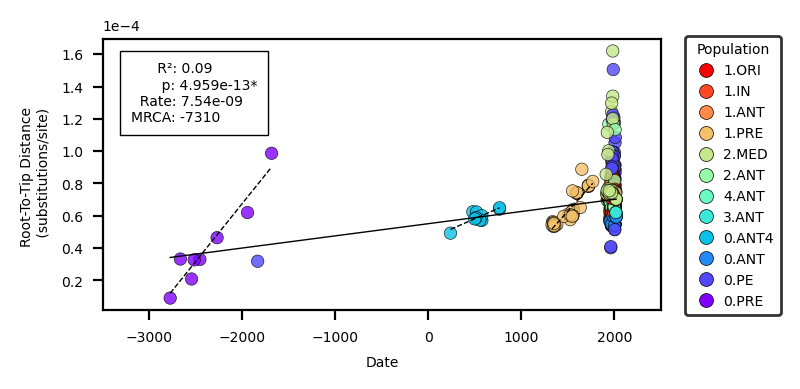

In [18]:
TARGET_RES = [720, 360]
DPI = 200
FIGSIZE = [TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE = 5
plt.rc("font", size=FONTSIZE)

                
dates = [float(date) for date in metadata_df["date_mean"]]
dists = [float(dist) for dist in metadata_df["root_rtt_dist"]]
dates_err = [float(date) for date in metadata_df["date_err"]]
color = [colors_dict[population] for population in metadata_df["population"]]


p_sig = ""
if bootstrap_mega_dict["All"]["reject"]:
    p_sig = "*"
    
corrected_p_value = bootstrap_mega_dict["All"]["corrected_p_value"]
pretty_p_value = corrected_p_value
if pretty_p_value != 1:
    pretty_p_value = "{:.3e}".format(corrected_p_value)

fig, axes = plt.subplots(1, figsize=FIGSIZE, dpi=DPI)
ax = axes

# plot regression line of populations with strict clock signal
for population in bootstrap_mega_dict:
    # Distance of population root to phylogeny root
    #print(bootstrap_mega_dict[population]["samples"])
    root_node =  divtree.common_ancestor(bootstrap_mega_dict[population]["samples"])
    root_dist = divtree.distance(root_node)
    
    y_adjust = [y + root_dist for y in bootstrap_mega_dict[population]["y"]]
    
    linestyle = "--" if population != "All" else "-"
    if bootstrap_mega_dict[population]["reject"]:
        sns.regplot(
            ax=ax,
            x=bootstrap_mega_dict[population]["x"],
            y=y_adjust,
            ci=None,
            scatter_kws={"s": 0},
            line_kws={"linewidth": 0.5, "zorder":10, "linestyle": linestyle},
            color="black",
        )

ax.scatter(
    x=dates,
    y=dists,
    s=20,
    color=color,
    ec="black",
    lw=0.25,
    label=None,
    alpha=0.8,
    zorder=3,
)

ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))  
ax.set_xlim(-3500, 2500)
ax.set_xlabel("Date")
ax.set_ylabel("Root-To-Tip Distance \n (substitutions/site)", fontsize=5)

# Use the stats from bootstrapping!
ax.annotate(
    ("      R²: {}".format(round(bootstrap_mega_dict["All"]["r_squared"], 2))
        + "\n       p: {}{}".format(pretty_p_value, p_sig)
        + "\n  Rate: {:.2e}".format(bootstrap_mega_dict["All"]["slope"])
        + "\nMRCA: {:.0f}".format(bootstrap_mega_dict["All"]["x_intercept"])
    ),
    xy=(0.05, 0.8),
    xycoords="axes fraction",
    size=5,
    ha="left",
    va="center",
    bbox=dict(fc="w", lw=0.5),
)

# Population legend
populations = list(colors_dict.keys())
populations.remove(NO_DATA_CHAR)
populations.reverse()

population_lines = [lines.Line2D([0], [0], color=colors_dict[population], lw=0, markersize=5, markeredgecolor="black", markeredgewidth=0.25, marker="o") 
                for population  in populations ]

population_legend = fig.legend(population_lines, 
           populations,
           #ncol=len(populations),
           ncol=1,
           loc="center", 
           bbox_to_anchor=(1, 0.5),
           frameon=True,
           borderpad=0.5, 
           handletextpad=0.25, 
           labelspacing=0.5,
           edgecolor="black",
           title="Population",
           fontsize=FONTSIZE,
           title_fontsize=FONTSIZE,
          )
population_legend.get_frame().set_linewidth(1)


out_path = os.path.join(out_dir, "rtt_all_population")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

### Multiplot by Population

Population: 0.PRE
Population: 0.PE
Population: 0.ANT
Population: 0.ANT4
Population: 3.ANT
Population: 4.ANT
Population: 2.ANT
Population: 2.MED
Population: 1.PRE
Population: 1.ANT
Population: 1.IN
Population: 1.ORI


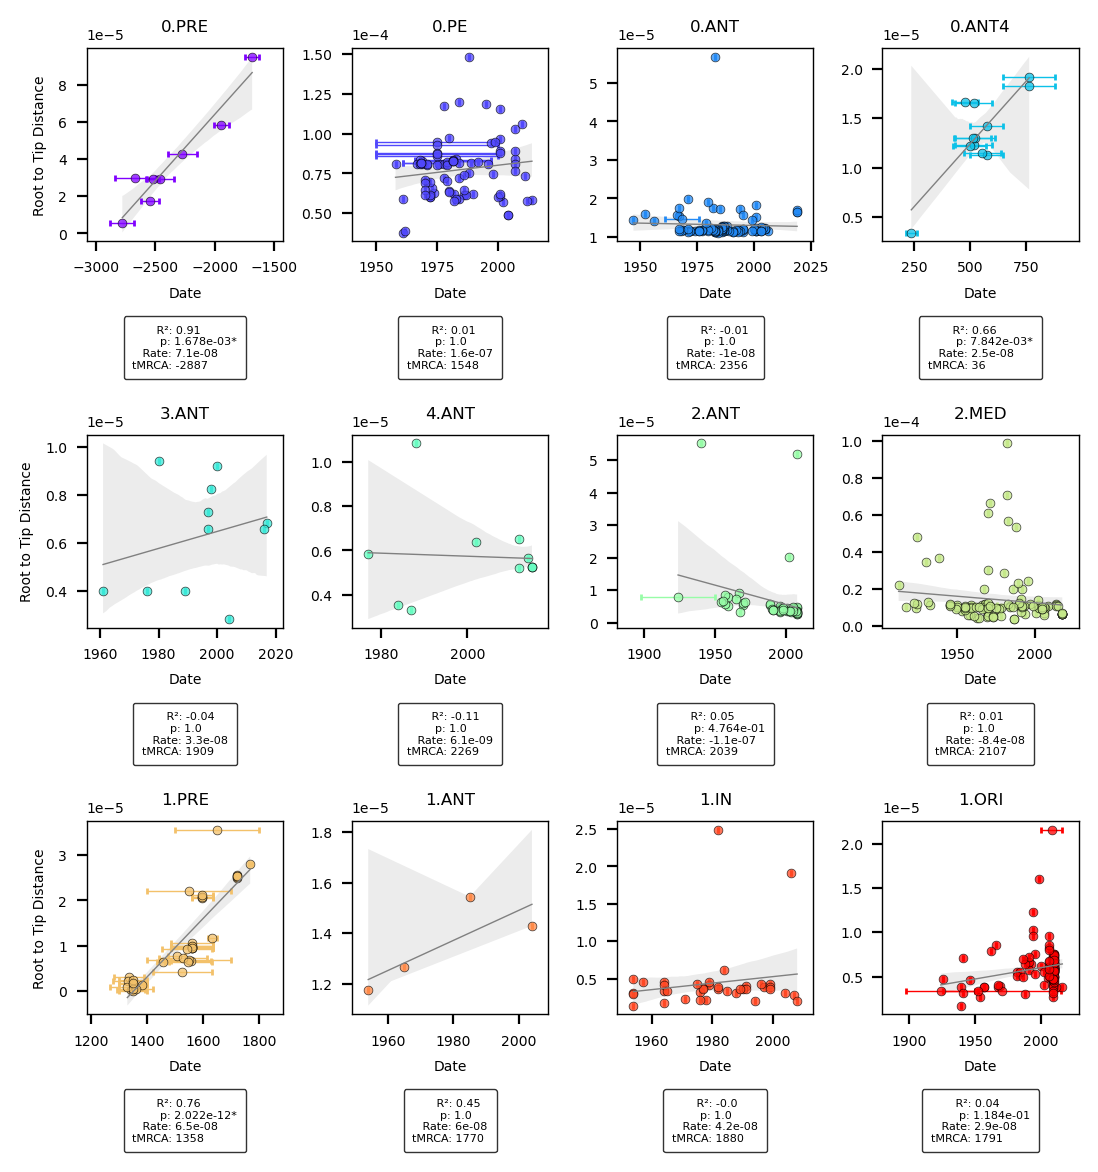

In [29]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280,  1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

reg_x = "date_mean"
#reg_y = "population_rtt_dist"
reg_y = "root_rtt_dist"
reg_err = "date_err"

nrow=3
ncol=4

fig, axes = plt.subplots(nrow,ncol,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.35, hspace=1)

i_row = 0
i_col = 0

for population in colors_dict:
    if population == NO_DATA_CHAR: continue
    df = metadata_df[metadata_df["population"] == population]
    
    if label not in bootstrap_mega_dict: continue
    print("Population:", population)
    
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]
    
    p_sig = ""
    if bootstrap_mega_dict[population]["reject"]:
        p_sig = "*"    
    corrected_p_value = bootstrap_mega_dict[population]["corrected_p_value"]
    pretty_p_value = corrected_p_value
    if pretty_p_value != 1:
        pretty_p_value = "{:.3e}".format(corrected_p_value)

    sns.regplot(
        ax=ax, 
        x=bootstrap_mega_dict[population]["x"],
        y=bootstrap_mega_dict[population]["y"], 
        ci=95,
        scatter_kws={"s": 0},
        line_kws={"linewidth" : 0.5},
        color="grey",
        label=(
        "       R²: {}".format(round(bootstrap_mega_dict[population]["r_squared"],2))
        + "\n        p: {}{}".format(pretty_p_value, p_sig)
        + "\n   Rate: {:.2}".format(bootstrap_mega_dict[population]["bootstrap_slope_peak"])  
        + "\ntMRCA: {}".format(round(bootstrap_mega_dict[population]["bootstrap_x_intercept_peak"]))                
        )
    )
    
    ax.errorbar(
        x=bootstrap_mega_dict[population]["x"],
        y=bootstrap_mega_dict[population]["y"], 
        xerr=bootstrap_mega_dict[population]["xerr"],       
        yerr=None,
        ls='none',
        color = bootstrap_mega_dict[population]["color"],  
        capsize=1,
        label=None,
        zorder=1,
        lw=0.5,
        )
    
    sns.scatterplot(
        ax=ax,
        x=bootstrap_mega_dict[population]["x"],
        y=bootstrap_mega_dict[population]["y"],  
        s=10,
        color = bootstrap_mega_dict[population]["color"], 
        ec = "black",
        alpha=0.75,
        zorder=2,
    )

    # Set xlimits
    xlim = ax.get_xlim()
    xrange = abs(xlim[1] - xlim[0])
    x_buff = xrange * 0.1
    new_xlim = [xlim[0] - x_buff, xlim[1] + x_buff]

    ax.set_xlim(new_xlim)

    ylim = ax.get_ylim()
    
    if ylim[0] < 0:
        ylim = ylim[0], ylim[1]
        
    yrange = abs(xlim[1] - xlim[0])
    y_buff = yrange * 0.1
    new_ylim = [ylim[0] - y_buff, ylim[1] + y_buff]
    #ax.set_ylim(-0.000005, 0.000105)
    

    # Format and position legend
    legend = ax.legend(
        borderpad=0.8, 
        handletextpad=-2, 
        edgecolor="black", 
        bbox_to_anchor=(0.5, -0.55), 
        loc='center',
        fontsize=FONTSIZE * 0.80,
    )
    frame = legend.get_frame().set_linewidth(0.5)
        
    # Format axis
    ax.set_title(population)

    if i_col == 0:
        ax.set_ylabel("Root to Tip Distance")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Date")    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    
    
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)    
            

    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1
    
    
out_path = os.path.join(out_dir, "rtt_regression_population")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

## Sampling Time Frame By R2

/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


y = 0.002x - 7.43e-07x² - 0.07


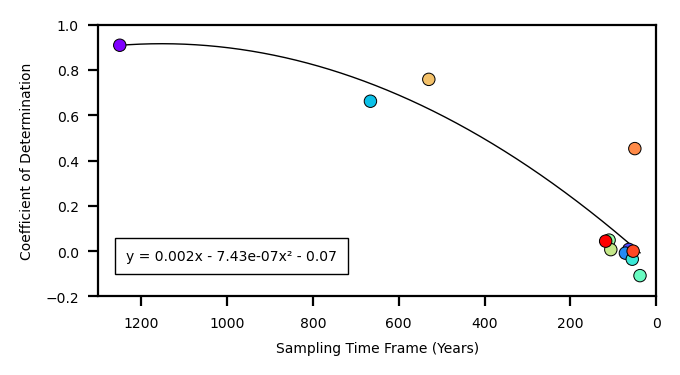

In [46]:
TARGET_RES = [720, 360]
DPI = 200
FIGSIZE = [TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE = 5
plt.rc("font", size=FONTSIZE)

fig, axes = plt.subplots(1, figsize=FIGSIZE, dpi=DPI)
ax = axes

x = []
y = []
c_list = []

for population in bootstrap_mega_dict:
    if population == "All": continue
    df = metadata_df[metadata_df["population"] == population]
    if "SAMEA104488961" in df.index:
        df.drop("SAMEA104488961", inplace=True)
    min_date, max_date = 10000,-10000
    for sample in df.index:
        sample_date_mean = df["date_mean"][sample]
        sample_date_err = df["date_err"][sample]
        sample_min_date = sample_date_mean - sample_date_err
        sample_max_date = sample_date_mean + sample_date_err
        if sample_min_date < min_date:
            min_date = sample_min_date
        if sample_max_date > max_date:
            max_date = sample_max_date
    
    diff_date = abs(max_date - min_date)
    r_squared = bootstrap_mega_dict[population]["r_squared"]
    color = df["population_color"][0]
    x.append(diff_date)
    y.append(r_squared)
    c_list.append(color)


# Fit an exponential model
def func_exp(x, a, b, c):
    return a * x + b * x**2 + c
popt, _ = scipy.optimize.curve_fit(func_exp, x, y)

# summarize the parameter values
a, b, c = popt
op_1 = "+"
if b < 0: op_1 = "-"
op_2 = "+"
if c < 0: op_2 = "-"
formula = "y = {:.3f}x {} {:.2e}x² {} {:.2f}".format(a,op_1,abs(b),op_2,abs(c))
print(formula)
# Create points for the line
x_line = np.arange(min(x), max(x), 1)
y_line = func_exp(x_line, a, b, c)
  
ax.plot(x_line, y_line, ls="-", lw=0.5, c="black", zorder=1)
    
sns.scatterplot(
        ax=ax,
        x=x,
        y=y,  
        s=20,
        c = c_list, 
        ec = "black",
        zorder=2,
    )


ax.set_xlim(1300,0)
ax.set_ylim(-0.2,1)
ax.set_xlabel("Sampling Time Frame (Years)")
ax.set_ylabel("Coefficient of Determination")

# Use the stats from bootstrapping!
ax.annotate(
    (formula),
    xy=(0.05, 0.15),
    xycoords="axes fraction",
    size=5,
    ha="left",
    va="center",
    bbox=dict(fc="w", lw=0.5),
)

out_path = os.path.join(out_dir, "rtt_curve_fit")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

In [28]:
display(metadata_df[metadata_df["population"] == "1.ANT"])

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,host_human,sequencing_technology,assembly_method,host_raw,host_order,population_color,population,geometry,root_rtt_dist,clade_rtt_dist,population_rtt_dist
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GCA_000169615.1_ASM16961v1_genomic,UG05-0454,2004.0,-17,Uganda,NA,1.533355,32.216658,NA,NA,Antiqua,1.ANT,1.ANT1,SAMN02404404,KEEP: Assembly Modern Morelli 2010 Cui 2013 Ke...,1,Africa,2004.0,17.0,0.0,1.533355,32.216658,Human,NA,NA,Homo sapiens,Human,#ff8a48,1.ANT,POINT (32.21666 1.53336),8.18048e-05,NA,1.42868e-05
GCA_003798225.1_ASM379822v1_genomic,FDAARGOS_601,1954.0,-67,Democratic Republic of the Congo,NA,-2.981434,23.822264,NA,NA,Antiqua,1.ANT,1.ANT1,SAMN10228581,KEEP: Assembly Modern,1,Africa,1954.0,67.0,0.0,-2.981434,23.822264,NA,Illumina HiSeq 4000,NA,UCC strain,NA,#ff8a48,1.ANT,POINT (23.82226 -2.98143),7.92608e-05,NA,1.17428e-05
GCA_000835005.1_ASM83500v1_genomic,Nairobi,1985.0,-36,Kenya,Nairobi,1.441968,38.431398,-1.30317,36.8261,Antiqua,1.ANT,1.ANT1,SAMN03256395,KEEP: Assembly Modern Placement,1,Africa,1985.0,36.0,0.0,-1.303169,36.826061,NA,454 GS FLX Titanium,NA,NA,NA,#ff8a48,1.ANT,POINT (36.82606 -1.30317),8.29601e-05,NA,1.54421e-05
GCA_000013825.1_ASM1382v1_genomic,Antiqua,1965.0,-56,Democratic Republic of the Congo,NA,-2.981434,23.822264,NA,NA,Antiqua,1.ANT,1.ANT1,SAMN02598369,KEEP: Assembly Modern Morelli 2010 Cui 2013 Ke...,1,Africa,1965.0,56.0,0.0,-2.981434,23.822264,Human,NA,NA,Homo sapiens,Human,#ff8a48,1.ANT,POINT (23.82226 -2.98143),8.01795e-05,NA,1.26615e-05


---

# 3. Geographic Structure

## All x All Distance Matrix and Mantel Test

In [ ]:
"""NUM_SAMPLES = len(metadata_gdf.index)
#NUM_SAMPLES = 200

gene_dist_mat = []
geo_dist_mat = []

all_dist_dict = {"gene":[],"geo":[], "mantel": {}}

i = 0
progress_size = 1
progress_next = 1

analysis_gdf = copy.deepcopy(metadata_gdf)

#for sample1 in metadata_gdf.index[:NUM_SAMPLES]:
for sample1 in analysis_gdf.index:
    progress = 100 * (i / len(analysis_gdf))
    if progress >= progress_next:
        print("{}%".format(round(progress,2)))
        progress_next += progress_size
    
    # Store distances in list for this sample
    geo_dist_list = []
    gene_dist_list = []
    
    geom1 = metadata_gdf["geometry"][sample1]
    coord1 = (geom1.y, geom1.x)     
    
    #for sample2 in metadata_gdf.index[:NUM_SAMPLES]:
    for sample2 in analysis_gdf.index:
        geom2 = metadata_gdf["geometry"][sample2]
        coord2 = (geom2.y, geom2.x)  

        # Calculate geographic and genetic distance
        geo_dist = round(geopy.distance.great_circle(coord1, coord2).km, 2)
        gene_dist = divtree.distance(sample1, sample2)   
        
        # Add to arrays
        geo_dist_list.append(geo_dist)
        gene_dist_list.append(gene_dist)   
        
    # Add to matrix
    all_dist_dict["geo"].append(geo_dist_list)
    all_dist_dict["gene"].append(gene_dist_list)
    
    # increment progress counter
    i += 1
    
print("100%")

# Check symmetry
"""

"""arr1 = np.array(geo_dist_mat)
arr2 = np.array(geo_dist_mat).T

print(np.all(np.abs(arr1-arr2) < 1e-10))

# Check symmetry
arr1 = np.array(gene_dist_mat)
arr2 = np.array(gene_dist_mat).T

print(np.all(np.abs(arr1-arr2) < 1e-10))
"""

"""
coeff, p_value, n = skbio_dist.mantel(all_dist_dict["gene"], all_dist_dict["geo"])
all_dist_dict["mantel"]["coeff"] = coeff
all_dist_dict["mantel"]["p_value"] = p_value
all_dist_dict["mantel"]["n"] = n

print(all_dist_dict["mantel"])"""

## Within Clade Distance Matrices and Mantel Test

In [ ]:
population_dist_dict = {}

for population in colors_dict:
    if population == NO_DATA_CHAR: continue
    df = metadata_df[metadata_df["population"] == population]
    if len(df) == 0: continue
    print(population)
    
    population_dist_dict[population] = {"gene":[],"geo":[], "mantel": {}}
    
    for sample1 in df.index:
        
        # Store distances in list for this sample
        geo_dist_list = []
        gene_dist_list = []        
        
        geom1 = metadata_gdf["geometry"][sample1]
        coord1 = (geom1.y, geom1.x)  
    
        for sample2 in df.index:
            geom2 = metadata_gdf["geometry"][sample2]
            coord2 = (geom2.y, geom2.x)  
            
            # Calculate geographic and genetic distance
            geo_dist = round(geopy.distance.great_circle(coord1, coord2).km, 8)
            gene_dist = divtree.distance(sample1, sample2)   

            # Add to arrays
            geo_dist_list.append(geo_dist)
            gene_dist_list.append(gene_dist)   

        # Add to matrix
        population_dist_dict[population]["geo"].append(geo_dist_list)
        population_dist_dict[population]["gene"].append(gene_dist_list)  
        
    # Mantel Test
    coeff, p_value, n = skbio_dist.mantel(population_dist_dict[population]["gene"], population_dist_dict[population]["geo"])
    population_dist_dict[population]["mantel"]["coeff"] = coeff
    population_dist_dict[population]["mantel"]["p_value"] = p_value
    population_dist_dict[population]["mantel"]["n"] = n

## Correct P Values

In [ ]:
# Correct p_values
raw_p_values = [population_dist_dict[population]["mantel"]["p_value"] for population in population_dist_dict]

# Add the p value from the all comparison to the end
#raw_p_values += [all_dist_dict["mantel"]["p_value"]]

reject, corrected_p_values, alphacSidak, alphacBonf = smmt.multipletests(raw_p_values, alpha = 0.05, method = "holm")

i = 0
for population in population_dist_dict:
    population_p_value = corrected_p_values[i]
    population_reject = reject[i]
    population_dist_dict[population]["mantel"]["corrected_p_value"] = population_p_value
    population_dist_dict[population]["mantel"]["reject"] = population_reject
    i += 1
    
# The last corrected p_value is associated with all
"""all_p_value = corrected_p_values[i]
all_reject = reject[i]
all_dist_dict["mantel"]["corrected_p_value"] = all_p_value
all_dist_dict["mantel"]["reject"] = all_reject"""
    
# Save results to a file
out_path = os.path.join(out_dir, "mantel.tsv")

with open(out_path, "w") as outfile:
    headers = "{}\t{}\t{}\t{}\t{}\t{}".format(
        "population",
        "coefficient",
        "raw_p_value",
        "n",
        "corrected_p_value",
        "reject",
    )
    outfile.write(headers + "\n")
    
    # All values
    #data = ["all"] + list(all_dist_dict["mantel"].values())
    #data_str = "\t".join([str(d) for d in data])
    #outfile.write(data_str + "\n")
    
    # Population Values
    for population in population_dist_dict:
        data = [population] + list(population_dist_dict[population]["mantel"].values())
        data_str = "\t".join([str(d) for d in data])
        outfile.write(data_str + "\n")

## Plot Populations All in 1

In [ ]:
"""# PLOT SETUP
TARGET_RES = [1280, 480]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)
fig, axes = plt.subplots(1,figsize=FIGSIZE, dpi=DPI)
"""
FONTSIZE=12
plt.rc('font', size=FONTSIZE)
DPI=400
FIGSIZE=[18,6]

fig, ax = plt.subplots(1,1, dpi=400, figsize=FIGSIZE)

#for spine in ax.spines:
#    ax.spines[spine].set_linewidth(0.5)

ax.set_ylabel("Genetic Distance\n(Substitutions/Site)", fontsize=FONTSIZE+2)
ax.set_xlabel("Great Circle Distance (km)", fontsize=FONTSIZE+2)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0)) 
    
# Plot by Population

populations=list(colors_dict.keys())
populations.remove("1.ORI"); populations.remove("1.PRE"); populations.remove("0.ANT4");
populations.reverse()
populations.append("1.ORI"); populations.append("1.PRE"); populations.append("0.ANT4");
for population in populations:
    
    if population not in population_dist_dict: continue
    
    print(population)        
    
    # Color
    color = colors_dict[population]
        
    # Extract the upper triangle of the distance matrices
    gene_dist_mat = np.array(population_dist_dict[population]["gene"])
    gene_dist_arr = gene_dist_mat[np.triu_indices(len(gene_dist_mat), k = 1)]

    geo_dist_mat = np.array(population_dist_dict[population]["geo"])
    geo_dist_arr = geo_dist_mat[np.triu_indices(len(geo_dist_mat), k = 1)]

    # Add to the all plot
    sns.scatterplot(
        ax=ax,
        x=geo_dist_arr,
        y=gene_dist_arr,
        color=color,       
        s=50,
        ec = "black", 
        lw=0.1,
        alpha=0.50,
        rasterized=True
    )  

# Population legend
populations = list(colors_dict.keys())
populations.remove(NO_DATA_CHAR)
populations.reverse()

population_lines = [lines.Line2D([0], [0], color=colors_dict[population], lw=0, markersize=10, markeredgecolor="black", markeredgewidth=0.25, marker="o") 
                for population in populations]

population_legend = fig.legend(population_lines, 
           populations,
           #ncol=len(populations),
           ncol=1,
           loc="center", 
           bbox_to_anchor=(1.1, 0.5),
           frameon=True,
           borderpad=0.5, 
           handletextpad=0.25, 
           labelspacing=0.5,
           edgecolor="black",
           title="Population",
           fontsize=FONTSIZE,
           title_fontsize=FONTSIZE+2,
          )
#population_legend.get_frame().set_linewidth(0.50)
   

out_path = os.path.join(out_dir, "mantel_all")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

## Plot Populations Multi Plot

In [ ]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

nrow=3
ncol=4

fig, axes = plt.subplots(nrow,ncol,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.35, hspace=0.80)


i_row = 0
i_col = 0

for population in colors_dict:
    if population == NO_DATA_CHAR: continue
    df = metadata_df[metadata_df["population"] == population]  
    print(population)
    
    if len(df) < 3:
        # Update axis
        if i_col == ncol - 1:
            i_col = 0
            i_row += 1
        else:
            i_col += 1        
        continue  
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]
    
    frame = legend.get_frame().set_linewidth(0.5)        
        
    # Format axis
    ax.set_title(population)
    

    if i_col == 0:
        ax.set_ylabel("Genetic Distance \n (substitutions/site)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Great Circle Distance (km)")
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    
    
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)  
        
    # Color
    color = colors_dict[population]
        
    # Prepare data
    gene_dist_mat = np.array(population_dist_dict[population]["gene"])
    gene_dist_arr = gene_dist_mat[np.triu_indices(len(gene_dist_mat), k = 1)]

    geo_dist_mat = np.array(population_dist_dict[population]["geo"])
    geo_dist_arr = geo_dist_mat[np.triu_indices(len(geo_dist_mat), k = 1)]

    # Add scatter
    sns.scatterplot(
        ax=ax,
        x=geo_dist_arr,
        y=gene_dist_arr,
        color=color,       
        s=1,
        ec = "black",      
        alpha=1.00,
        zorder=2,      
    )
    
    sns.kdeplot(
        ax=ax,
        x=geo_dist_arr, 
        y=gene_dist_arr, 
        fill=True,
        zorder=1,
        color=color, 
        alpha=0.5,
        thresh=0.05,
    )
    
    # Dummy plot for label
    p_sig = ""
    if population_dist_dict[population]["mantel"]["reject"]:
        p_sig = "*"
    sns.scatterplot(
        ax=ax,
        x=[0],
        y=[0],
        s=0,
        label=(
            "Coefficient: {}".format(round(population_dist_dict[population]["mantel"]["coeff"],2))
            + "\n               p: {:.2e}{}".format(population_dist_dict[population]["mantel"]["corrected_p_value"],p_sig)      
        + "\n               N: {}".format(population_dist_dict[population]["mantel"]["n"])              
            )          
    )
    
    # Format and position legend
    legend = ax.legend(
        borderpad=0.8, 
        handletextpad=-2, 
        edgecolor="black", 
        bbox_to_anchor=(0.5, -0.45), 
        loc='center',
        fontsize=FONTSIZE * 0.80,
    )
    frame = legend.get_frame().set_linewidth(0.5)    
            

    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1 
        
        
        
out_path = os.path.join(out_dir, "mantel_populations")
plt.savefig(out_path + ".png", bbox_inches="tight", dpi=400)
plt.savefig(out_path + ".svg", bbox_inches="tight") 

---
# 1.ORI Example

## Geographic Distances

In [ ]:
continent_colors_dict = {c:"" for c in set(metadata_df["continent"])}

# Create the custom color map (pyplot)
cmap = plt.get_cmap("rainbow", len(continent_colors_dict))
# Convert the color map to a list of RGB values
cmaplist = [cmap(i) for i in range(cmap.N)]
# Convert RGB values to hex colors
attr_hex = [colors.to_hex(col) for col in cmaplist]

# Assign colors to value
for continent, color in zip(continent_colors_dict, attr_hex):
    continent_colors_dict[continent] = color
# Add NA
continent_colors_dict["Intercontinental"] = "#c4c4c4"

print(continent_colors_dict)

In [ ]:
population_list = list(colors_dict.keys())
population_list.remove(NO_DATA_CHAR)

dist_dict = {}

for population in population_list:
    print(population)
    
    dist_dict[population] = {}
    
    df = metadata_gdf[metadata_gdf["population"] == population]
    #human_df = df[df["host_order"] == "Human"]
    #non_human_df = df[(df["host_order"] != "Human") & (df["host_order"] != NO_DATA_CHAR)]
    #label_list = ["human", "non_human"]
    #df_list = [human_df, non_human_df]    
    #
    #if len(human_df) > 0 and len(non_human_df) > 0:
    #    all_df = df
    #    label_list.append("all")
    #    df_list.append(all_df)
    label_list = ["all"]
    df_list = [df]
    
    for label,df in zip(label_list, df_list):
        if len(df) < 3: continue
        print(label)
        dist_dict[population][label] = {"gene":[],"geo":[], "mantel": {}, "continent": []}
        
        for sample1 in df.index:

            # Store distances in list for this sample
            geo_dist_list = []
            gene_dist_list = []  
            continent_list = []

            # Get geographic coordinates of sample 1
            geom1 = metadata_gdf["geometry"][sample1]
            coord1 = (geom1.y, geom1.x)
            continent1 = metadata_gdf["continent"][sample1]

            for sample2 in df.index:
                geom2 = metadata_gdf["geometry"][sample2]
                coord2 = (geom2.y, geom2.x) 
                continent2 = metadata_gdf["continent"][sample2]            

                # Calculate geographic and genetic distance
                geo_dist = round(geopy.distance.great_circle(coord1, coord2).km, 8)
                gene_dist = divtree.distance(sample1, sample2)   

                if continent1 != continent2:
                    continent = "Intercontinental"
                else:
                    continent = continent1

                # Add to arrays
                geo_dist_list.append(geo_dist)
                gene_dist_list.append(gene_dist) 
                continent_list.append(continent)


            # Add to matrix
            dist_dict[population][label]["geo"].append(geo_dist_list)
            dist_dict[population][label]["gene"].append(gene_dist_list)  
            dist_dict[population][label]["continent"].append(continent_list)  

        # Mantel Test
        coeff, p_value, n = skbio_dist.mantel(dist_dict[population][label]["gene"], dist_dict[population][label]["geo"])
        dist_dict[population][label]["mantel"]["coeff"] = coeff
        dist_dict[population][label]["mantel"]["p_value"] = p_value
        dist_dict[population][label]["mantel"]["n"] = n
        
        print("\t", dist_dict[population][label]["mantel"])
    

## Correct P Values

In [ ]:
# Correct p_values
raw_p_values = []
for population in dist_dict:
    for label in dist_dict[population]:
        values = dist_dict[population][label]["mantel"]["p_value"]
        raw_p_values.append(values)

reject, corrected_p_values, alphacSidak, alphacBonf = smmt.multipletests(raw_p_values, alpha = 0.05, method = "holm")

i = 0

for population in dist_dict:
    for label in dist_dict[population]:
        label_p_value = corrected_p_values[i]
        label_reject = reject[i]
        dist_dict[population][label]["mantel"]["corrected_p_value"] = label_p_value
        dist_dict[population][label]["mantel"]["reject"] = label_reject
        i += 1   
        
        print(population, label, dist_dict[population][label]["mantel"])
        
    
# Save results to a file
out_path = os.path.join(out_dir, "mantel_host.tsv")

with open(out_path, "w") as outfile:
    headers = "{}\t{}\t{}\t{}\t{}\t{}\t{}".format(
        "population",
        "label",
        "coefficient",
        "raw_p_value",
        "n",
        "corrected_p_value",
        "reject",
    )
    outfile.write(headers + "\n")
    
    # Population Values
    for population in dist_dict:
        for label in dist_dict[population]:
            data = [population] + [label] + list(dist_dict[population][label]["mantel"].values())
            data_str = "\t".join([str(d) for d in data])
            outfile.write(data_str + "\n")        

## Plot

In [ ]:
# ---------------------------------------
# PLOT SETUP
FONTSIZE=12
plt.rc('font', size=FONTSIZE)


for population in dist_dict:
    if population != "1.ORI": continue
    color = colors_dict[population]
    for label in dist_dict[population]:
        if label != "all": continue
        print(population, label)
        
        # Extract the upper triangle of the distance matrices
        gene_dist_mat = np.array(dist_dict[population][label]["gene"])
        gene_dist_arr = gene_dist_mat[np.triu_indices(len(gene_dist_mat), k = 1)]

        geo_dist_mat = np.array(dist_dict[population][label]["geo"])
        geo_dist_arr = geo_dist_mat[np.triu_indices(len(geo_dist_mat), k = 1)]
        
        continent_mat = np.array(dist_dict[population][label]["continent"])
        continent_arr = continent_mat[np.triu_indices(len(continent_mat), k = 1)]
        continent_colors = [continent_colors_dict[c] for c in continent_arr]

        g = sns.JointGrid(       
            x=geo_dist_arr,
            y=gene_dist_arr,
            space=0,
        )
        
        g.plot_joint(
            sns.scatterplot,
            color=color,     
            #c=continent_colors,
            s=30,
            ec = "black",      
            alpha=1.00,
            zorder=2,   
            rasterized=True, 
        )
        
        g.plot_joint(
            sns.kdeplot,
            fill=True,
            zorder=1,
            color=color,
            alpha=0.5,
            thresh=0.05,
        )    

        g.plot_marginals(
            sns.kdeplot, 
            bw_adjust=0.3,
            fill=True,
            color=color,
        )   
        
        g.fig.suptitle("{}\n{}".format(population,label), x=0, y=1)
        g.ax_joint.set_ylabel("Genetic Distance \n (Substitutions/Site)", fontsize=FONTSIZE+2)
        g.ax_joint.set_xlabel("Great Circle Distance\n(km)", fontsize=FONTSIZE+2)

        #g.ax_joint.set_xlim(-7000,25000)

        # Dummy plot for label
        p_sig = ""
        if dist_dict[population][label]["mantel"]["reject"]:
            p_sig = "*"
        sns.scatterplot(
            ax=g.ax_joint,
            x=[0],
            y=[0],
            s=0,
            label=(
                "Coefficient: {}".format(round(dist_dict[population][label]["mantel"]["coeff"],2))
                + "\n               p: {:.2e}{}".format(dist_dict[population][label]["mantel"]["corrected_p_value"],p_sig)      
            + "\n               N: {}".format(dist_dict[population][label]["mantel"]["n"])              
                )          
        )

        # Format and position legend
        legend = g.ax_joint.legend(
            borderpad=0.8, 
            handletextpad=-2, 
            edgecolor="black", 
            bbox_to_anchor=(0.5, -0.3), 
            loc='center',
            fontsize=FONTSIZE - 2,
        )


        out_path = os.path.join(out_dir, "mantel_{}_{}".format(population, label))
        print(out_path)
        #plt.savefig(out_path + ".png", bbox_inches="tight")
        #plt.savefig(out_path + ".svg", bbox_inches="tight") 

---

# 4. Timeline

In [ ]:
# PLOT SETUP
TARGET_RES = [1280, 240]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

fig, axes = plt.subplots(1,4,figsize=FIGSIZE, dpi=DPI, sharey=False)
fig.subplots_adjust(wspace=0.25)

# Bronze Age
ax = axes[-4]
ax.set_title("Bronze Age")
ax_range = [-3001, -1]
ax.set_xlim(ax_range)
ax.set_ylim(0,16)
df = metadata_gdf[(metadata_gdf["date_mean"] > ax_range[0]) & (metadata_gdf["date_mean"] <= ax_range[1]) ]
sns.histplot(
    ax=ax, 
    x=df["date_mean"], 
    multiple="stack",    
    hue=df["population"], 
    palette=colors_dict, 
    binwidth=200,
    alpha=1.0,
    lw=0.25,
)
ax.legend().remove()

# Roman
ax = axes[-3]
ax.set_title("Late Antiquity")
ax.set_ylim(0,16)

ax_range = [0, 999]
ax.set_xlim(ax_range)
df = metadata_gdf[(metadata_gdf["date_mean"] > ax_range[0]) & (metadata_gdf["date_mean"] <= ax_range[1]) ]
sns.histplot(
    ax=ax, 
    x=df["date_mean"], 
    multiple="stack",    
    hue=df["population"], 
    palette=colors_dict, 
    binwidth=50,
    alpha=1.0,
    lw=0.25,
)
ax.legend().remove()


# Medieval
ax = axes[-2]
ax.set_title("Medieval/Early Modern")
ax.set_ylim(0,16)
ax_range = [999, 1899]
ax.set_xlim(ax_range)
df = metadata_gdf[(metadata_gdf["date_mean"] > ax_range[0]) & (metadata_gdf["date_mean"] <= ax_range[1]) ]
sns.histplot(
    ax=ax, 
    x=df["date_mean"], 
    multiple="stack",    
    hue=df["population"], 
    palette=colors_dict, 
    binwidth=50,
    alpha=1.0,
    lw=0.25,
)
ax.legend().remove()

# Modern
ax = axes[-1]
ax.set_title("Modern")
ax_range = [1899, 2020]
ax.set_xlim(ax_range)
ax.set_ylim(0,160)
df = metadata_gdf[(metadata_gdf["date_mean"] > ax_range[0]) & (metadata_gdf["date_mean"] <= ax_range[1]) ]
sns.histplot(
    ax=ax, 
    x=df["date_mean"], 
    multiple="stack",    
    hue=df["population"], 
    palette=colors_dict, 
    binwidth=10,
    alpha=1.0,
    lw=0.25,
)
ax.legend().remove()

for ax in axes:
    ax.set_ylabel("")
    ax.set_xlabel("Collection Date")
axes[0].set_ylabel("Number of Genomes")

for ax in axes:
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0)
    ax.spines["bottom"].set_linewidth(0.5)
    ax.spines["left"].set_linewidth(0.5)
    
# Population legend
populations = list(colors_dict.keys())
populations.remove(NO_DATA_CHAR)
populations.reverse()

population_lines = [lines.Line2D([0], [0], color=colors_dict[population], lw=0, markersize=5, markeredgecolor="black", markeredgewidth=0.25, marker="s") 
                for population in populations]

population_legend = fig.legend(population_lines, 
           populations,
           #ncol=len(populations),
           ncol=1,
           loc="center", 
           bbox_to_anchor=(0.95, 0.50),
           frameon=True,
           borderpad=0.5, 
           handletextpad=0.25, 
           labelspacing=0.5,
           edgecolor="black",
           title="Population",
           fontsize=FONTSIZE,
           title_fontsize=FONTSIZE,
          )
population_legend.get_frame().set_linewidth(0.50)
    
out_path = os.path.join(out_dir, "timeline_all")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

---

# Export

## Metadata

In [ ]:
out_path_metadata = os.path.join(out_dir, "metadata.tsv")
metadata_df.to_csv(out_path_metadata, sep="\t", index=True)

In [ ]:
print(size_by_coord)